In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from anchor.visualize import MODALITY_TO_COLOR, MODALITY_ORDER, MODALITY_PALETTE
modality_order = MODALITY_ORDER

sns.set(style='ticks', context='talk', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline

%load_ext autoreload
%autoreload 2

folder = 'figures'

import flotilla
study = flotilla.embark('singlecell_pnm_figure4_voyages', 
                        flotilla_dir='/projects/ps-yeolab/obotvinnik/flotilla_projects/')
# study = flotilla.embark('singlecell_pnm_figure1_supplementary_post_splicing_filtering')

/home/obotvinnik/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/obotvinnik/workspace-git/flotilla/flotilla/__init__.py:65: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  load_species_data=load_species_data)


2016-10-20 16:43:27	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure4_voyages/datapackage.json
2016-10-20 16:43:27	Parsing datapackage to create a Study object
https://s3-us-west-2.amazonaws.com/flotilla-projects/ercc/ERCC_Controls.txt has not been downloaded before.
2016-10-20 16:43:57 	Initializing Study
2016-10-20 16:43:57 	Initializing Predictor configuration manager for Study
2016-10-20 16:43:57	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-10-20 16:43:57	Added ExtraTreesClassifier to default predictors
2016-10-20 16:43:57	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-10-20 16:43:57	Added ExtraTreesRegressor to default predictors
2016-10-20 16:43:57	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-10-20 16:43:57	Added GradientBoostingClassifier to defa

Error loading species hg19 data: HTTP Error 404: Not Found

In [4]:
pooled_metadata = study.metadata.data.query('pooled ==  True')
print(pooled_metadata.shape)
pooled_metadata.head()

(8, 10)


single pooled phenotype neuron progenitor stressed craig_venter  \
CVN_17   False   True       NPC  False       True    False         True   
CVN_35   False   True       NPC  False       True    False         True   
M2_05    False   True        MN   True      False    False         True   
M2nd_13  False   True        MN   True      False    False         True   
M2nd_21  False   True        MN   True      False    False         True   

        differentiation_batch split outlier  
CVN_17                    NaN   NaN   False  
CVN_35                    NaN   NaN   False  
M2_05                  batch1   NaN   False  
M2nd_13                batch2   NaN   False  
M2nd_21                batch2   NaN   False

In [6]:
from bonvoyage import Waypoints

ws = Waypoints()

pooled_waypoints = study.splicing.pooled.groupby(study.sample_id_to_phenotype).apply(
    lambda x: ws.fit_transform(x.dropna(how='all', axis=1)))
print(pooled_waypoints.shape)
pooled_waypoints.head()

(36087, 2)


0         1
phenotype                                                                
MN        exon:chr10:101165513-101165617:-@exon:chr10:101...  0  0.666667
          exon:chr10:101480744-101480825:-@exon:chr10:101...  0  1.000000
          exon:chr10:101507014-101507147:+@exon:chr10:101...  0  0.000000
          exon:chr10:101507014-101507147:+@exon:chr10:101...  0  0.666667
          exon:chr10:101964263-101964414:-@exon:chr10:101...  0  1.000000

In [13]:
pkm_event = u'exon:chr15:72499069-72499221:-@exon:chr15:72495363-72495529:-@exon:chr15:72494795-72494961:-@exon:chr15:72492815-72492996:-'

In [14]:
folder

'figures'

In [15]:
waypoints_folder = '{}/waypoints/'.format(folder)
! mkdir -p $waypoints_folder

In [16]:
import bonvoyage

In [19]:
modalities_grouped = study.supplemental.modalities_tidy.groupby('phenotype')

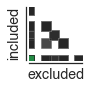

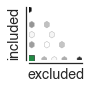

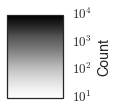

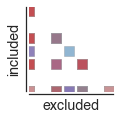

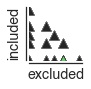

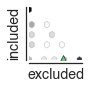

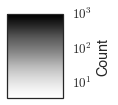

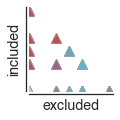

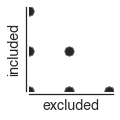

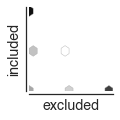

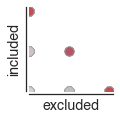

In [21]:
kinds = 'scatter', 'hexbin'

colorbar_ticklabels = [r'$10^{' + str(i) + '}$' for i in range(1, 5)]

for phenotype, df in pooled_waypoints.groupby(level=0, axis=0):
    df.index = df.index.droplevel(0)
    marker = study.phenotype_to_marker[phenotype]
    
#     six.print_(df.head())
    
    for kind in kinds:
        fig, ax = plt.subplots(figsize=(1.5, 1.5))
        kwargs = dict(rasterized=True, alpha=0.2, marker=marker) if kind == 'scatter' else dict(gridsize=10, vmax=4)
        bonvoyage.waypointplot(df, ax=ax, kind=kind, **kwargs)

        try:
            # Double-plot PKM
            x, y = df.loc[pkm_event]
            color = study.phenotype_to_color[phenotype]
            ax.plot(x, y, marker, markerfacecolor=None, markeredgecolor='k', markeredgewidth=.5, color=color)
            ax.set(title='')
        except KeyError:
            continue
            
        ax.set(title='')
        fig.tight_layout()
#         sns.despine(offset=2)
        fig.savefig('{}/{}_{}_pooled.pdf'.format(waypoints_folder, phenotype, kind), dpi=300)
        
        if kind == 'hexbin':
            fig_colorbar, ax_colorbar = plt.subplots(figsize=(1, 1.5))
            plt.colorbar(ax.collections[0], cax=ax_colorbar, 
                         orientation='vertical',  label='Count', 
                         ticks=[1, 2, 3, 4])#mpl.ticker.MaxNLocator(4))
            ax_colorbar.yaxis.set_ticklabels(colorbar_ticklabels)
#             fig_colorbar.tight_layout()
            fig_colorbar.savefig('{}/{}_{}_pooled_colorbar.pdf'.format(waypoints_folder, phenotype, kind), dpi=300)
        
        
    fig, ax = plt.subplots(figsize=(1.5, 1.5))
    modality_df = modalities_grouped.get_group(phenotype)
    groupby = modality_df.set_index('event_id')['modality']
    bonvoyage.waypointplot(df, ax=ax, kind='scatter', rasterized=True, features_groupby=groupby, marker=marker)
    ax.set(title='')
#     sns.despine(offset=3)
#     fig.tight_layout()
    fig.savefig('{}/{}_scatter_modality.pdf'.format(waypoints_folder, phenotype), dpi=300)


In [32]:
from bonvoyage.voyages import Voyages

v = Voyages()

pooled_voyages = v.voyages(pooled_waypoints, study.phenotype_transitions)
pooled_voyages.head()

ImportError: cannot import name Voyages

In [29]:
pooled_voyages.shape

(20581, 8)

In [33]:
from bonvoyage.visualize import voyageplot

In [34]:
genes_to_plot = '''AASS
BPTF
C17orf76-AS1
C6orf48
CALU
CCT4
CHTOP
CMC2
COX20
CYP20A1
EIF3E
EIF4A2
ELP5
ERP29
FAM126A
FOXP1
GRB2
HMGCR
HNRNPAB
ITGB1BP1
JAKMIP2
JAKMIP2
LAMP2
LDHA
MAP4K4
PKM
PPHLN1
PPIP5K2
RAB7A
RWDD1
SCP2
SEPHS1
SERPING1
SKA2
SNAP25
SOCS4
TIMM8B
TM2D1
TTC28-AS1
XRN2
ZNHIT1
AASS
BARD1
BAZ2B
BCAS4
BOD1
BPTF
C15orf40
C17orf76-AS1
C6orf48
CALU
CCDC25
CCT4
CDCA7
CHTOP
CKB
CMC2
CMC2
COX20
CXADR
CYP20A1
DGUOK
DHX36
EIF3E
EIF4A2
EIF5
ELP5
ERP29
EWSR1
FAM126A
FOXP1
GGCT
GRB2
HIF1A
HIF1A
HMGCR
HNRNPAB
HNRNPC
HNRNPDL
IMPDH2
INTS12
ISCU
ITGB1BP1
JAKMIP2
JAKMIP2
KAT6A
LAMP2
LDHA
LITAF
LUC7L3
LUZP1
MAP4K4
MEIS2
METTL3
MZT2B
OCIAD1
ORMDL1
PIGF
PKM
PPHLN1
PPIP5K2
PPP6R3
PRMT2
PRMT2
PRRC2C
QSER1
RAB7A
RBBP4
RPAIN
RWDD1
RWDD2B
SCP2
SEPHS1
SERPING1
SETD5-AS1
SKA2
SNAP23
SNAP25
SOCS4
STRA13
SUMF2
SYNCRIP
TARDBP
TFAM
THYN1
TIMM8B
TIMM8B
TM2D1
TOR1AIP2
TRNT1
TTC28-AS1
WASF2
XRN2
YAF2
ZNHIT1
ZNF207
USMG5
IDI1
JMJD1C
RPS24
TIMM8B
THYN1
RBM14-RBM4,RBM4
TMEM126B
FAM60A
PFDN5
PCBP2
HNRNPC
TPM1
FAM96A
C17orf76-AS1
C17orf76-AS1
C17orf76-AS1
ZNF207
RPAIN
RPAIN
SKA2
SNHG16
ANAPC11
STRA13
RNMT
SMIM7,CTC-429P9.4
DMKN
FDPS
HNRNPR
HNRNPR
ZBTB8OS
AKR1A1
AKR1A1
NASP
C1orf52
EIF6
RBM39
ZFAS1
ZFAS1
GNAS
ADSL
MRPL33
SRSF7
DGUOK
DPH3
PDCD10
EIF4A2
EIF4A2
EIF4A2
MIR302B
RBPJ
OCIAD2
HNRNPD
HMGCS1
HDDC2
NQO2
C6orf48
SYNCRIP
AASS
CALU
HNRNPA2B1
GGCT
SNHG6
TERF1
C8orf59
TCEAL8
WBP5
'''.split()
genes_to_plot = set(genes_to_plot)

In [35]:
import itertools

# genes_to_plot = 'MAP4K4', 'MEAF6', 'EWSR1', 'PPHLN1', 'STRA13', 'ZNF207', 'THYN1', 'RPS24', 'PKM'
events_to_plot = set(itertools.chain(*[study.splicing.maybe_renamed_to_feature_id(x) for x in genes_to_plot
                                       if (study.splicing.feature_data.gene_name == x).sum() > 0]))
events_to_plot

{'exon:chr10:105152128-105152223:-@exon:chr10:105151948-105152040:-@exon:chr10:105148798-105148923:-',
 'exon:chr10:105155503-105155831:-@exon:chr10:105153956-105154151:-@exon:chr10:105152128-105152223:-',
 'exon:chr10:105156166-105156223:-@exon:chr10:105153956-105154151:-@exon:chr10:105152128-105152223:-',
 'exon:chr10:105156166-105156223:-@exon:chr10:105155503-105155789:-@exon:chr10:105152128-105152223:-',
 'exon:chr10:105156166-105156223:-@exon:chr10:105155503-105155789:-@exon:chr10:105153956-105154151:-@exon:chr10:105152128-105152223:-',
 'exon:chr10:1094804-1095110:-@exon:chr10:1089939-1090111:-@exon:chr10:1089241-1089333:-',
 'exon:chr10:13370351-13370450:-@exon:chr10:13364835-13365047:-@exon:chr10:13360590-13361356:-',
 'exon:chr10:13390000-13390280:-@exon:chr10:13386758-13387028:-@exon:chr10:13380705-13380808:-',
 'exon:chr10:60145980-60146098:+@exon:chr10:60146410-60146476:+@exon:chr10:60147950-60148020:+',
 'exon:chr10:60148430-60148579:+@exon:chr10:60150525-60150620:+@exon:c

In [37]:
voyageplot_folder = '{}/voyageplots'.format(folder)
! mkdir -p $voyageplot_folder

In [49]:
# waypoints_index = study.set_index('Unnamed: 1', append=True)
pooled_waypoints_index = pooled_waypoints.swaplevel(0, 1)
pooled_waypoints_index = pooled_waypoints_index.sort_index()
pooled_waypoints_index.head()

0         1
                                                   phenotype             
exon:chr10:100190328-100190427:-@exon:chr10:100... NPC        0  1.000000
                                                   iPSC       1  0.000000
exon:chr10:100195392-100195529:-@exon:chr10:100... NPC        0  1.000000
exon:chr10:101165513-101165617:-@exon:chr10:101... MN         0  0.666667
                                                   NPC        0  1.000000

In [50]:
range(3)

[0, 1, 2]

In [51]:

singles_waypoints_index = study.supplemental.waypoints.set_index('Unnamed: 1', append=True)
singles_waypoints_index = singles_waypoints_index.swaplevel(0, 1)
singles_waypoints_index = singles_waypoints_index.sort_index()
singles_waypoints_index.head()

0  \
Unnamed: 1                                         phenotype             
exon:chr10:100190328-100190427:-@exon:chr10:100... iPSC       0.833333   
exon:chr10:100195392-100195529:-@exon:chr10:100... iPSC       0.187500   
exon:chr10:101165513-101165617:-@exon:chr10:101... MN         0.000000   
                                                   NPC        0.000000   
                                                   iPSC       0.000000   

                                                                     1  
Unnamed: 1                                         phenotype            
exon:chr10:100190328-100190427:-@exon:chr10:100... iPSC       0.166667  
exon:chr10:100195392-100195529:-@exon:chr10:100... iPSC       0.812500  
exon:chr10:101165513-101165617:-@exon:chr10:101... MN         1.000000  
                                                   NPC        1.000000  
                                                   iPSC       0.965517

In [52]:
study.phenotype_order

[u'iPSC', u'NPC', u'MN']

MN      (0.317416388848, 0.317416388848, 0.317416388848)
NPC     (0.586082300252, 0.586082300252, 0.586082300252)
iPSC    (0.850119193862, 0.850119193862, 0.850119193862)
dtype: object

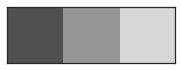

In [53]:
pooled_phenotype_to_color = pd.Series(dict(zip(study.phenotype_order, sns.color_palette('Greys', n_colors=3))))
sns.palplot(pooled_phenotype_to_color)
pooled_phenotype_to_color

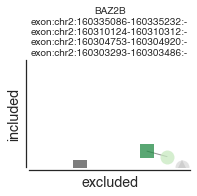

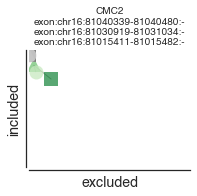

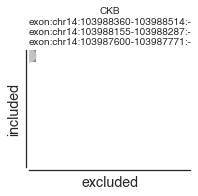

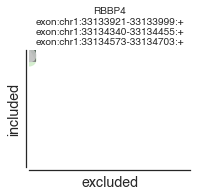

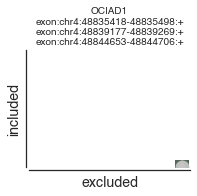

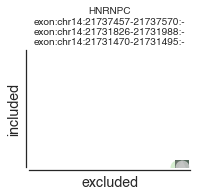

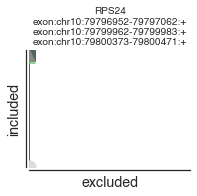

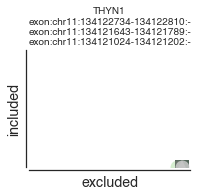

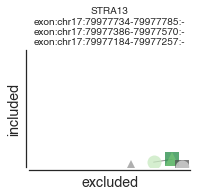

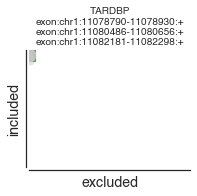

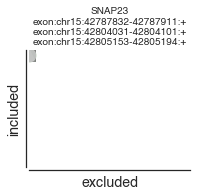

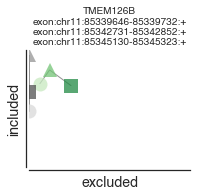

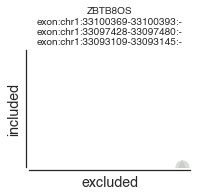

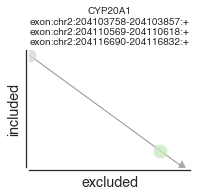

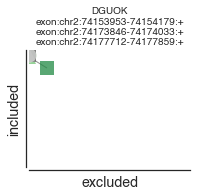

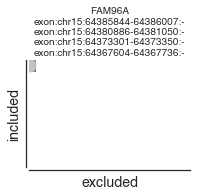

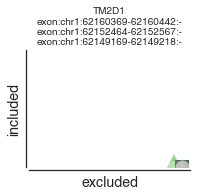

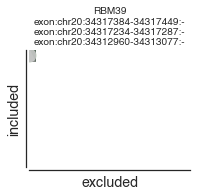

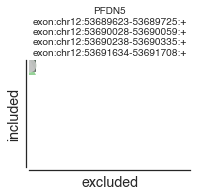

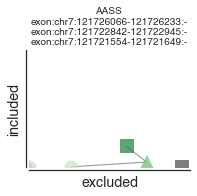

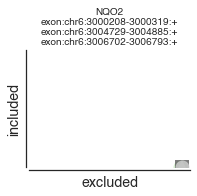

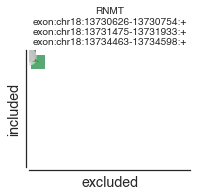

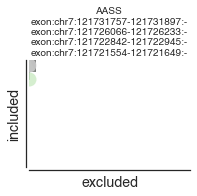

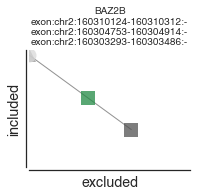

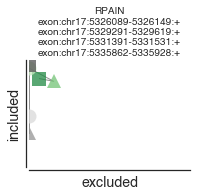

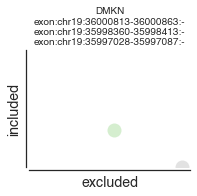

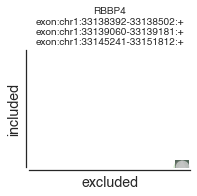

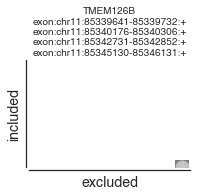

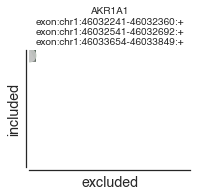

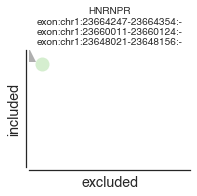

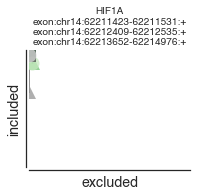

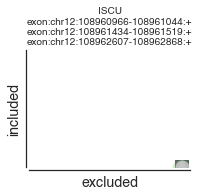

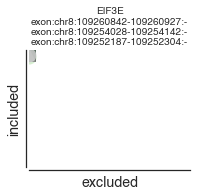

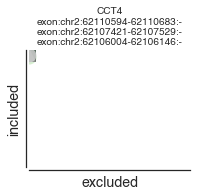

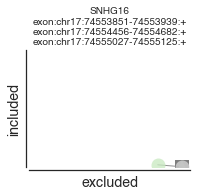

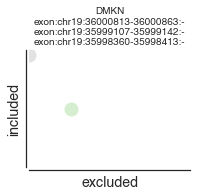

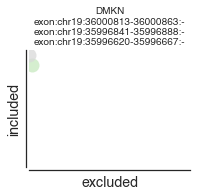

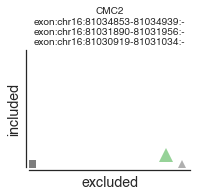

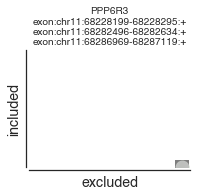

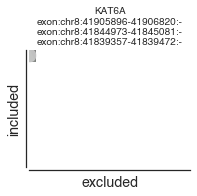

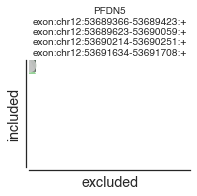

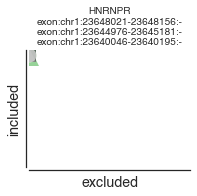

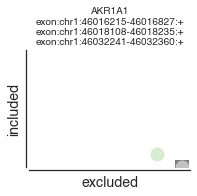

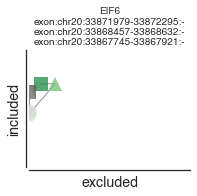

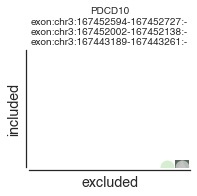

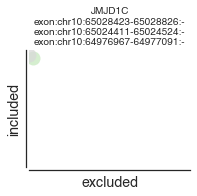

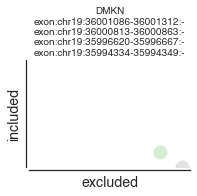

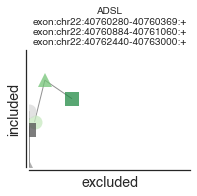

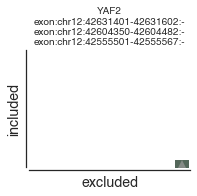

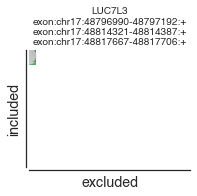

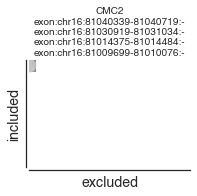

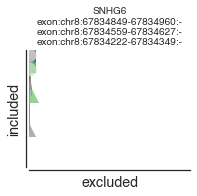

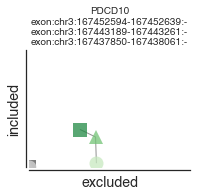

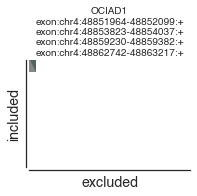

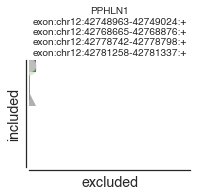

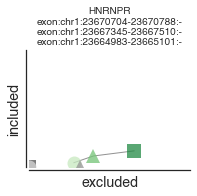

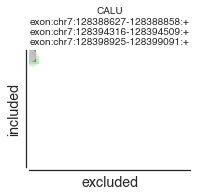

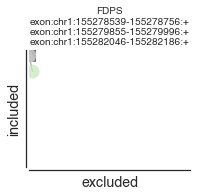

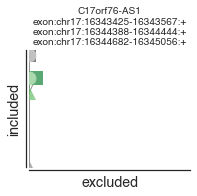

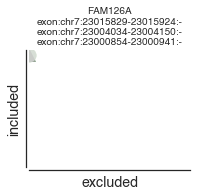

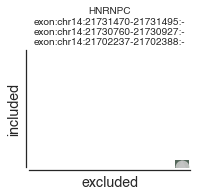

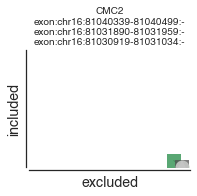

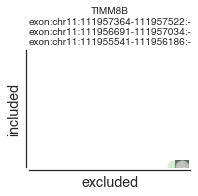

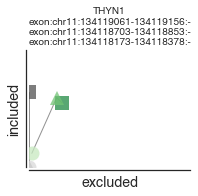

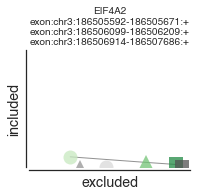

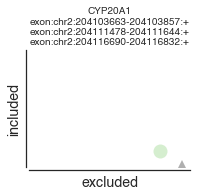

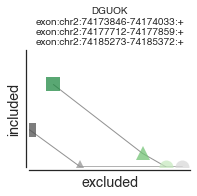

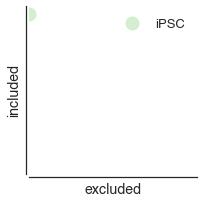

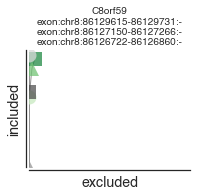

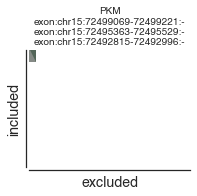

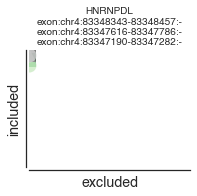

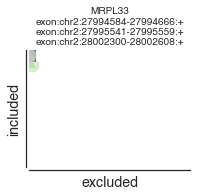

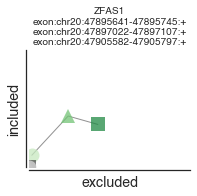

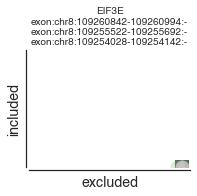

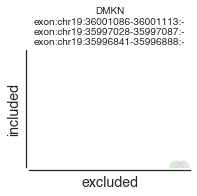

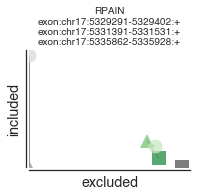

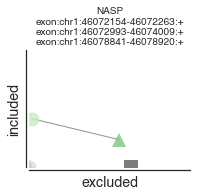

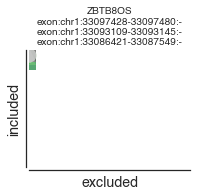

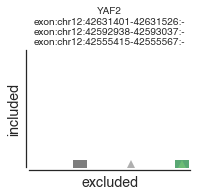

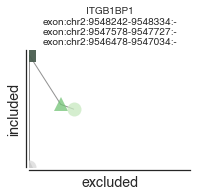

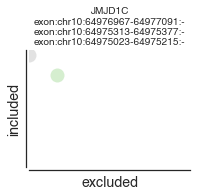

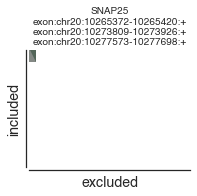

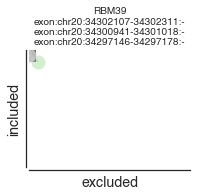

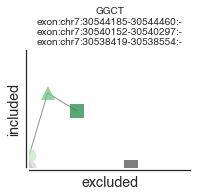

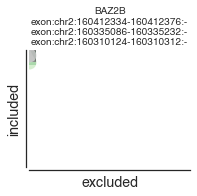

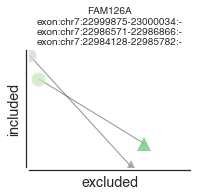

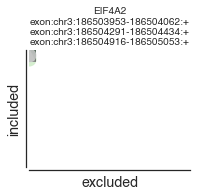

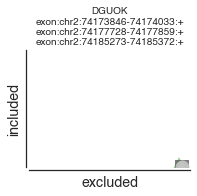

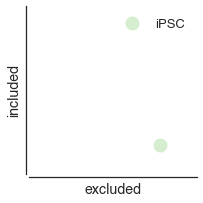

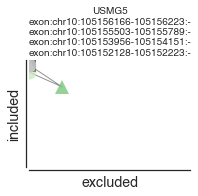

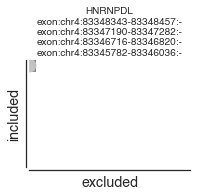

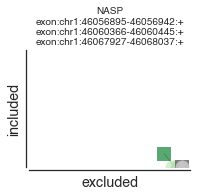

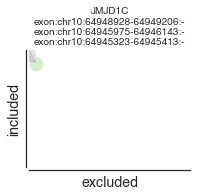

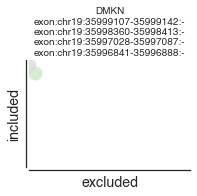

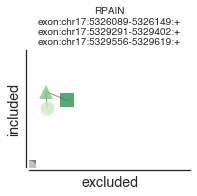

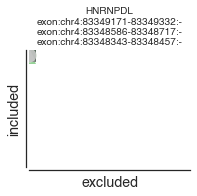

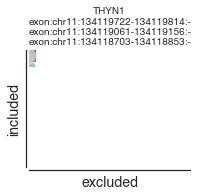

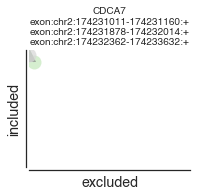

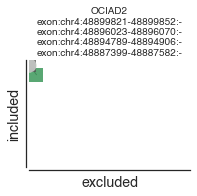

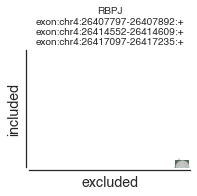

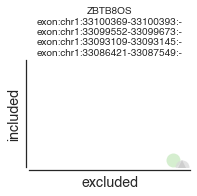

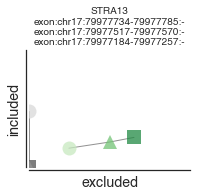

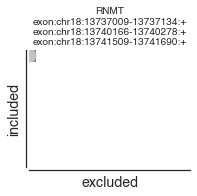

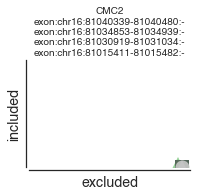

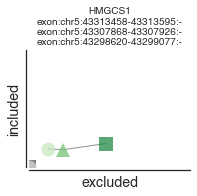

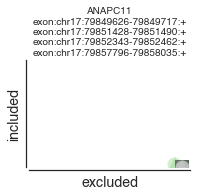

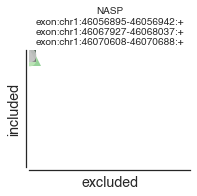

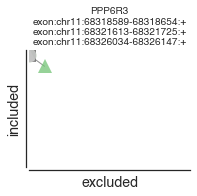

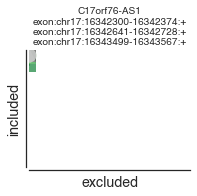

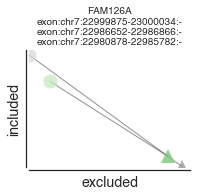

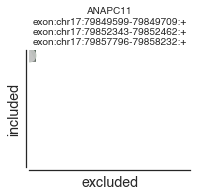

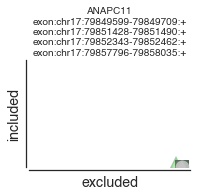

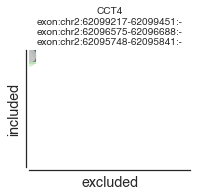

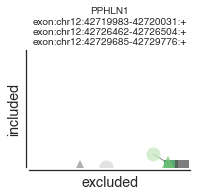

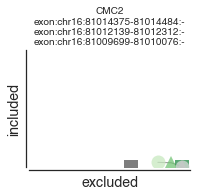

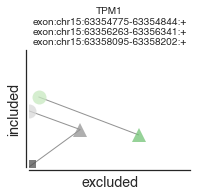

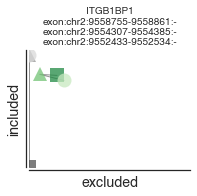

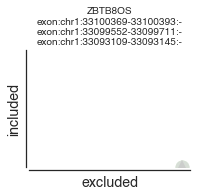

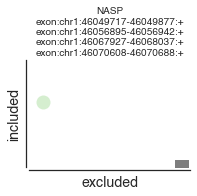

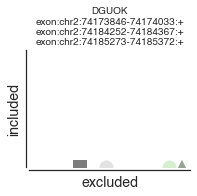

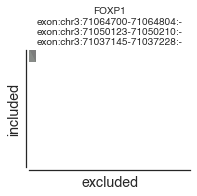

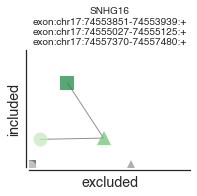

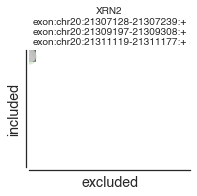

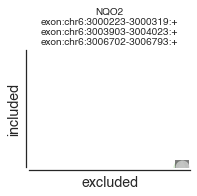

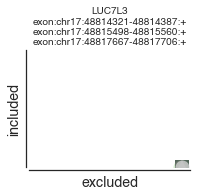

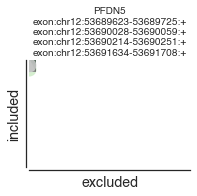

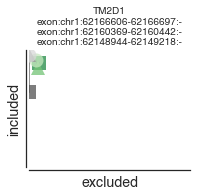

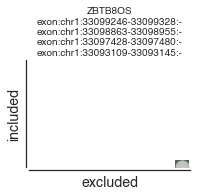

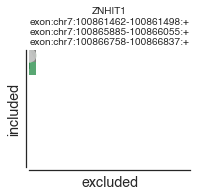

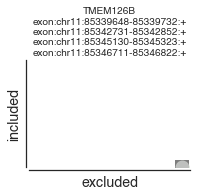

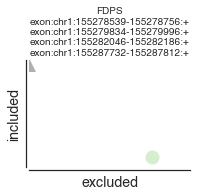

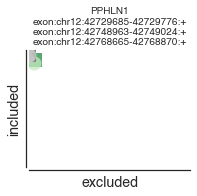

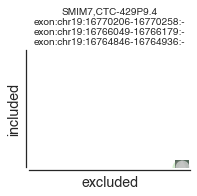

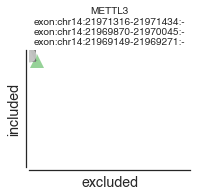

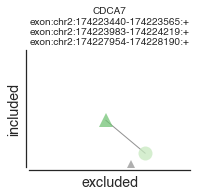

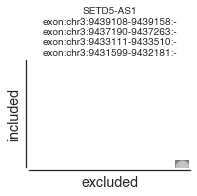

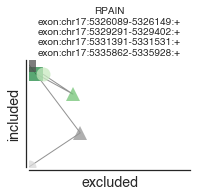

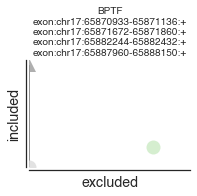

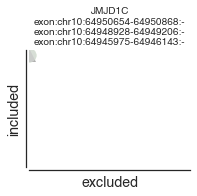

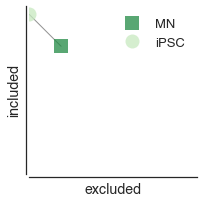

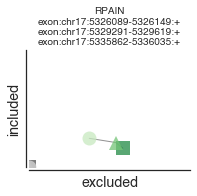

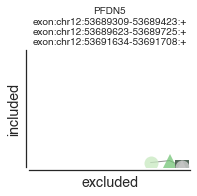

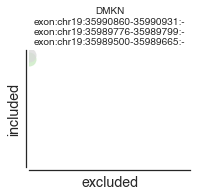

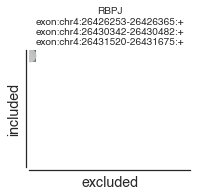

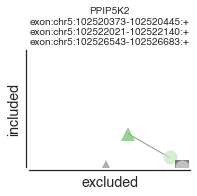

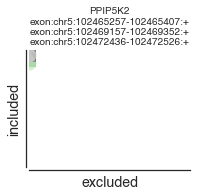

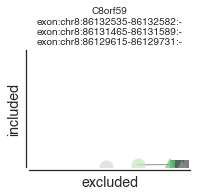

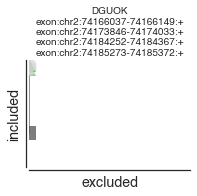

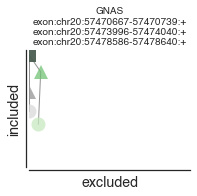

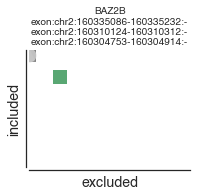

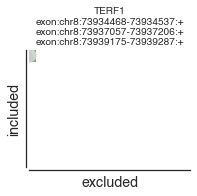

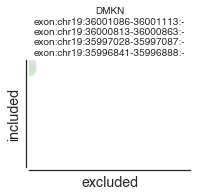

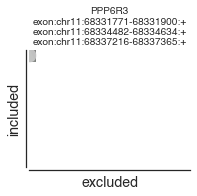

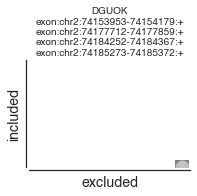

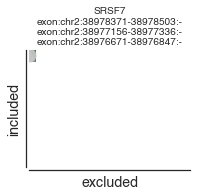

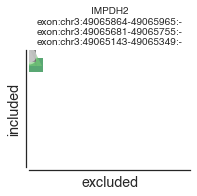

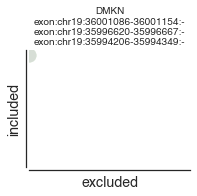

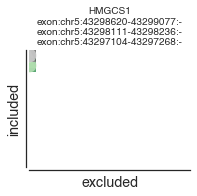

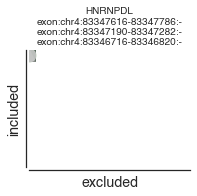

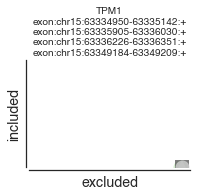

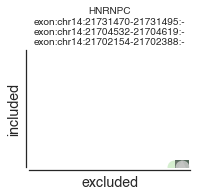

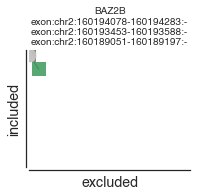

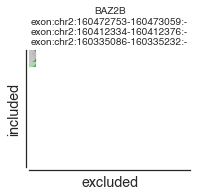

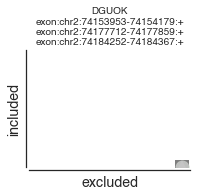

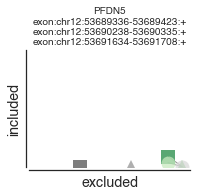

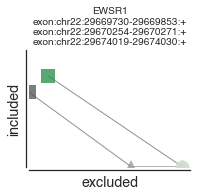

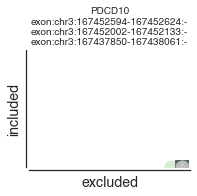

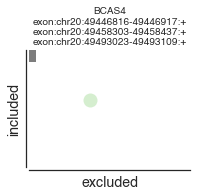

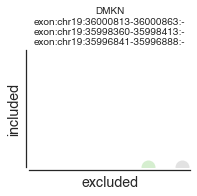

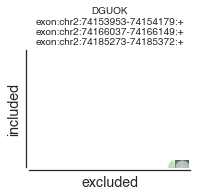

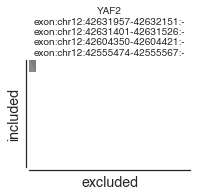

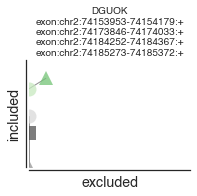

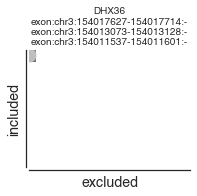

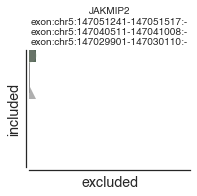

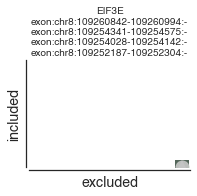

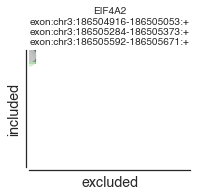

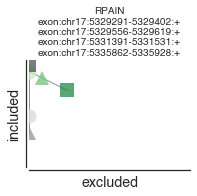

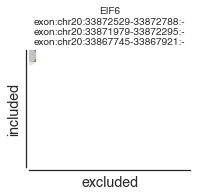

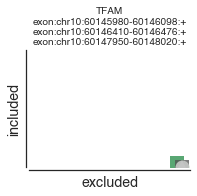

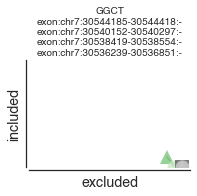

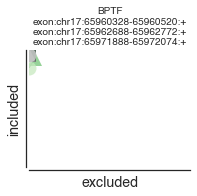

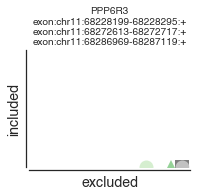

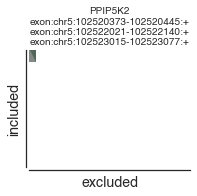

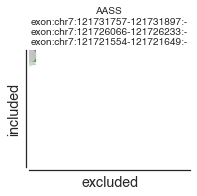

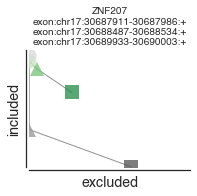

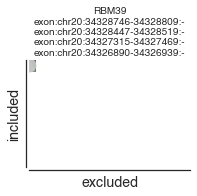

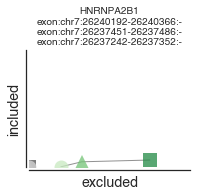

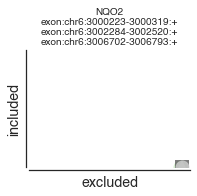

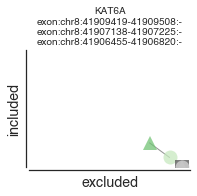

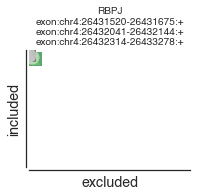

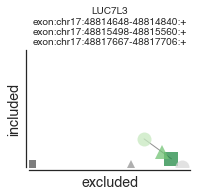

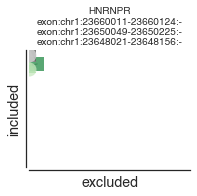

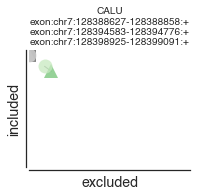

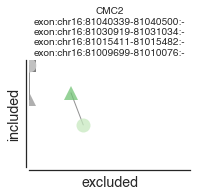

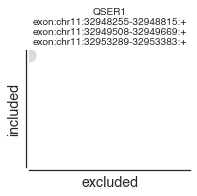

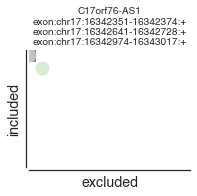

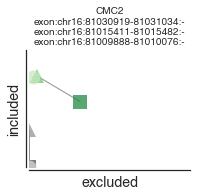

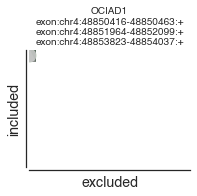

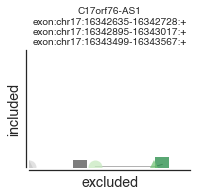

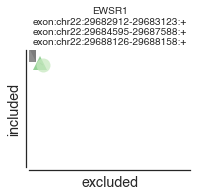

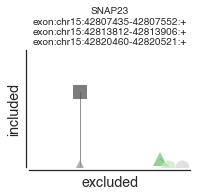

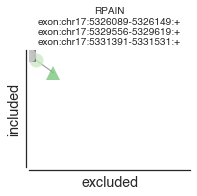

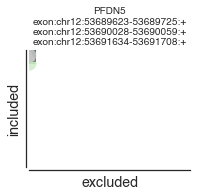

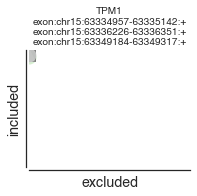

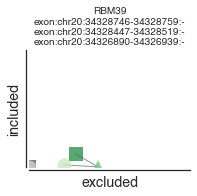

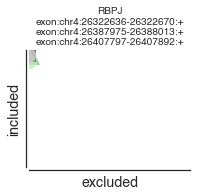

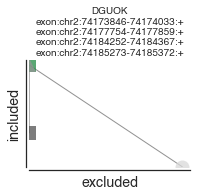

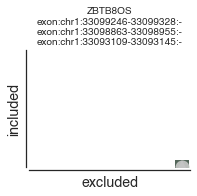

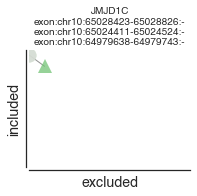

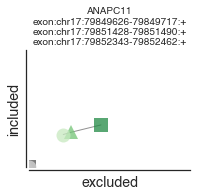

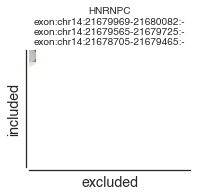

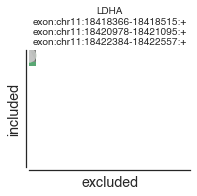

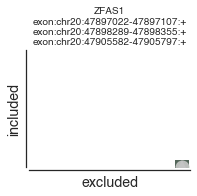

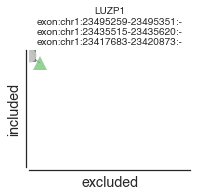

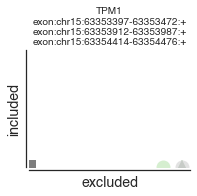

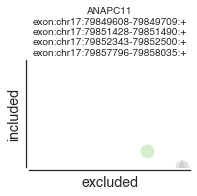

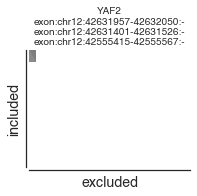

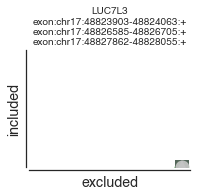

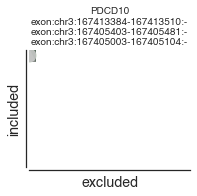

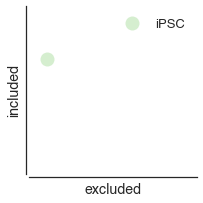

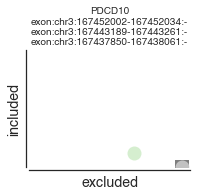

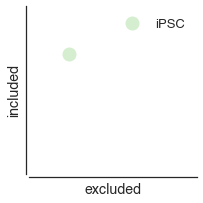

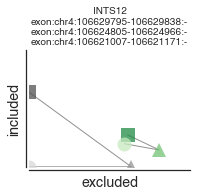

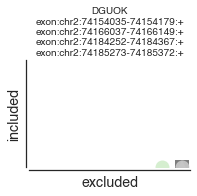

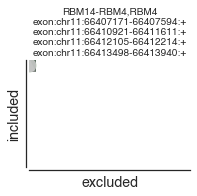

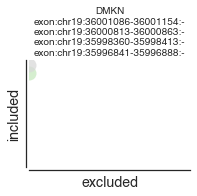

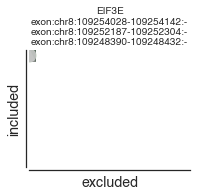

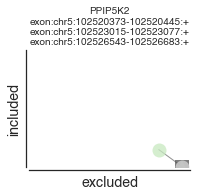

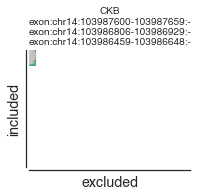

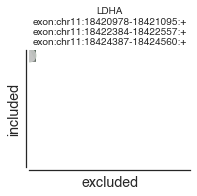

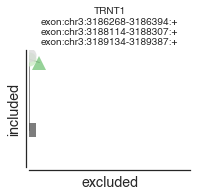

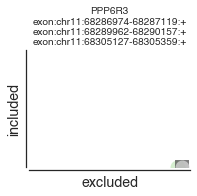

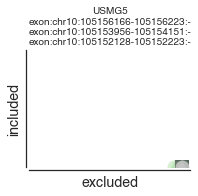

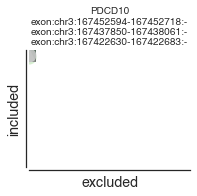

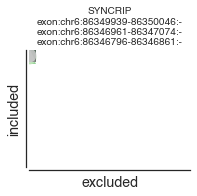

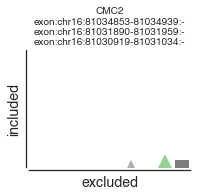

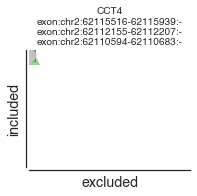

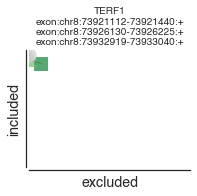

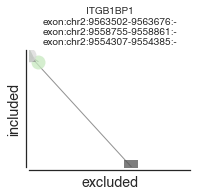

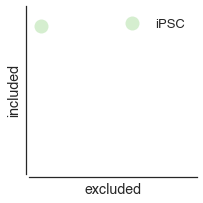

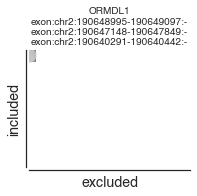

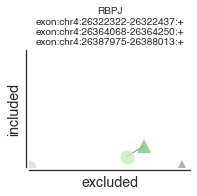

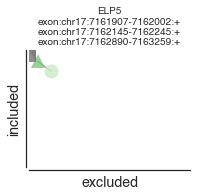

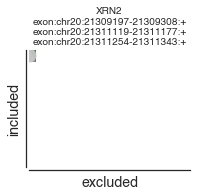

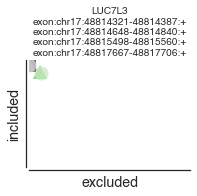

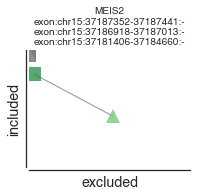

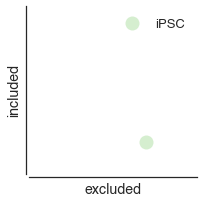

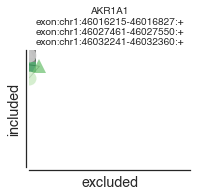

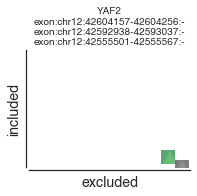

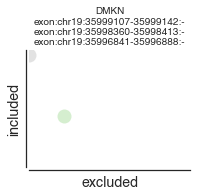

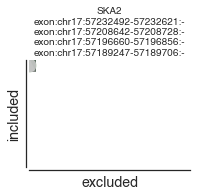

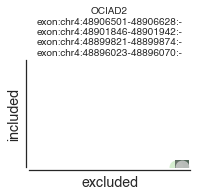

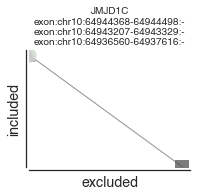

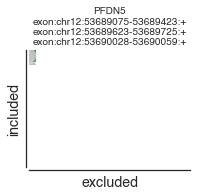

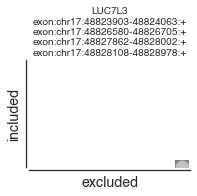

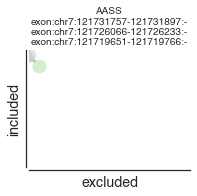

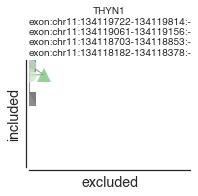

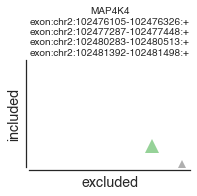

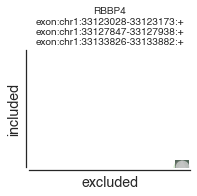

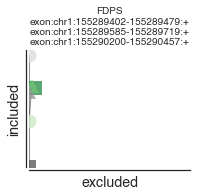

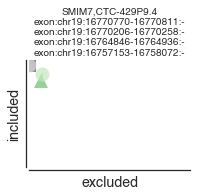

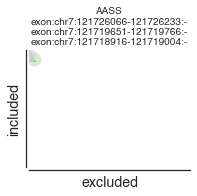

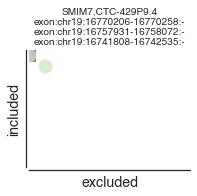

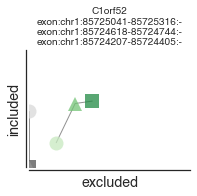

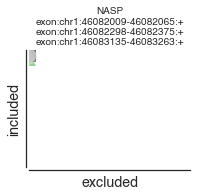

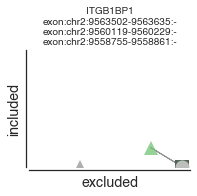

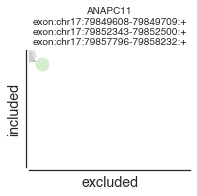

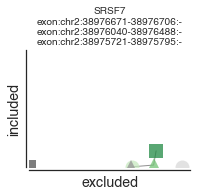

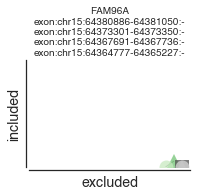

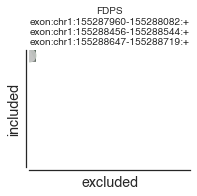

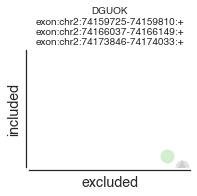

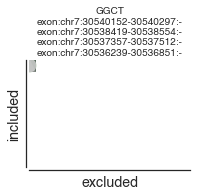

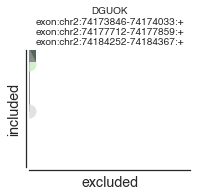

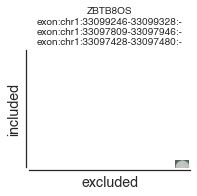

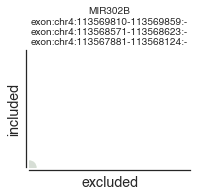

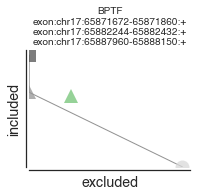

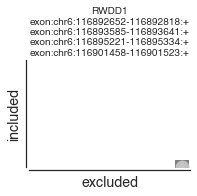

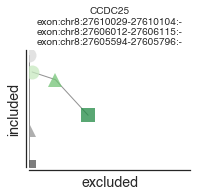

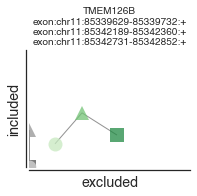

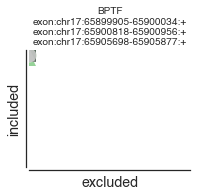

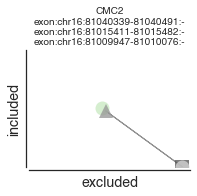

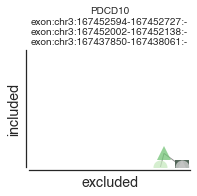

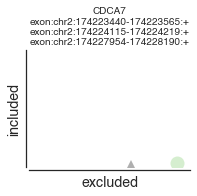

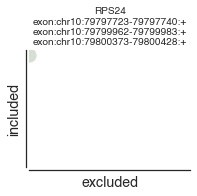

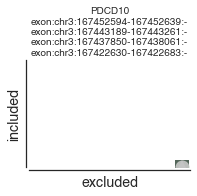

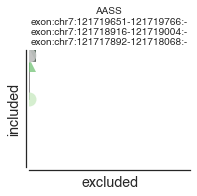

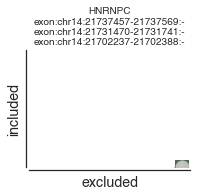

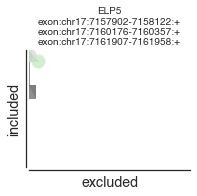

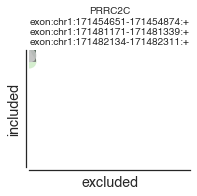

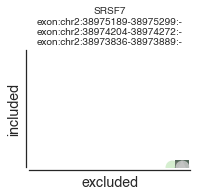

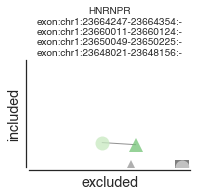

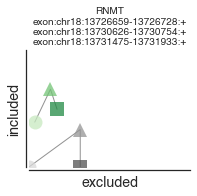

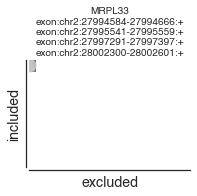

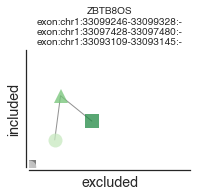

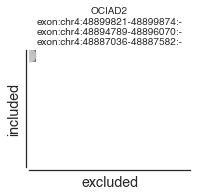

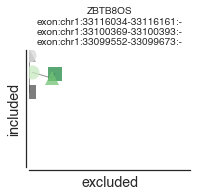

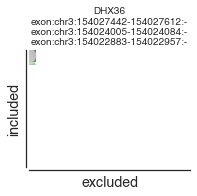

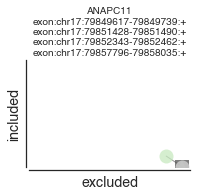

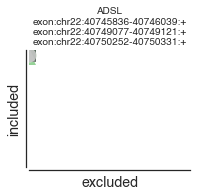

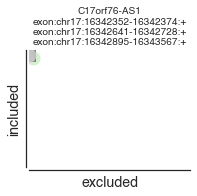

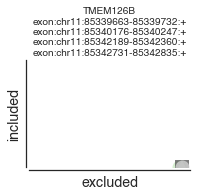

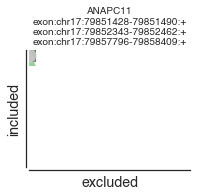

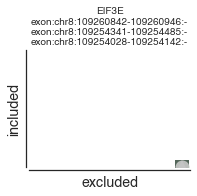

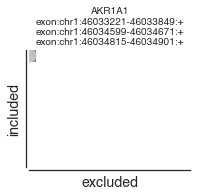

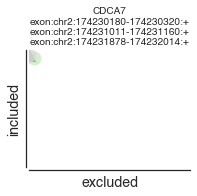

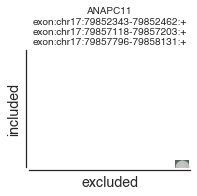

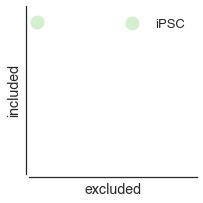

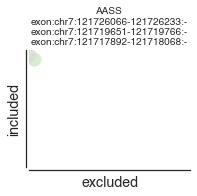

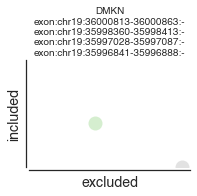

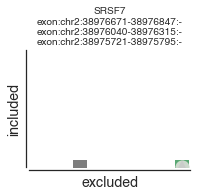

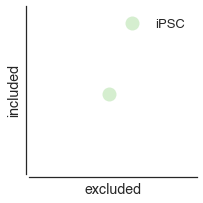

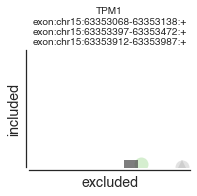

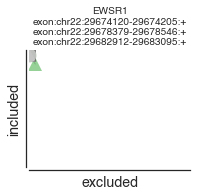

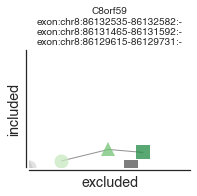

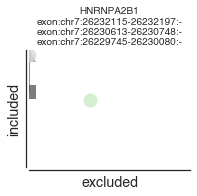

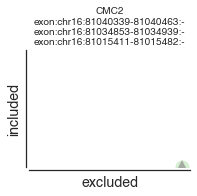

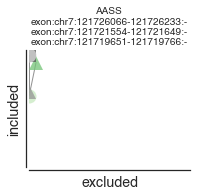

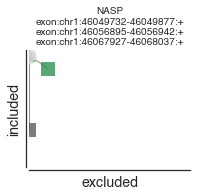

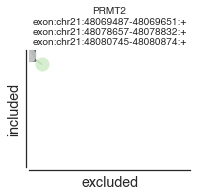

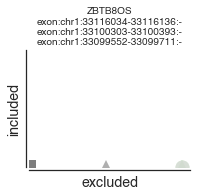

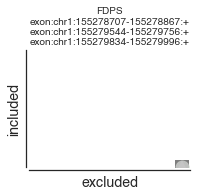

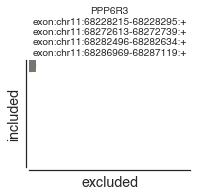

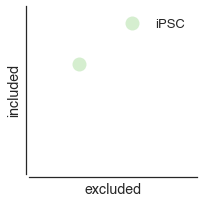

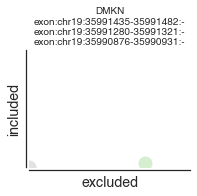

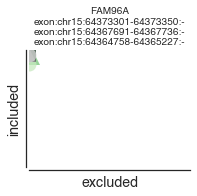

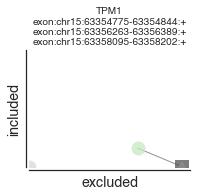

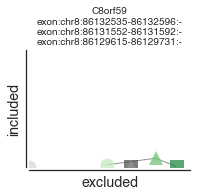

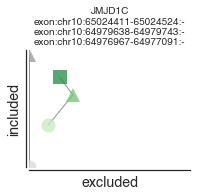

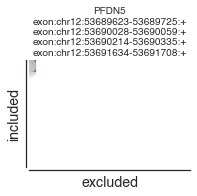

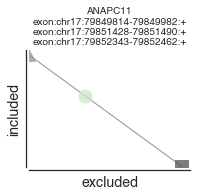

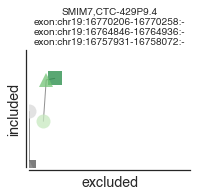

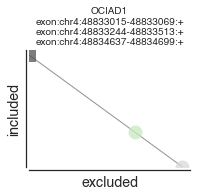

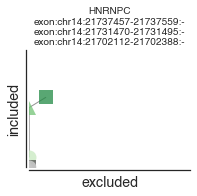

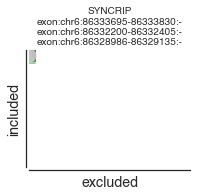

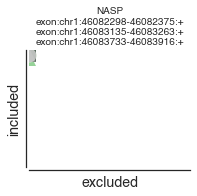

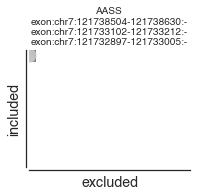

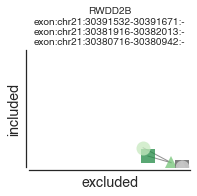

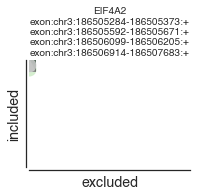

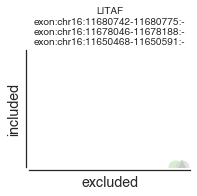

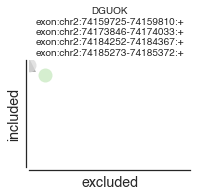

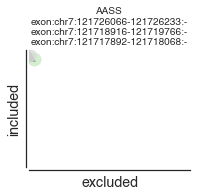

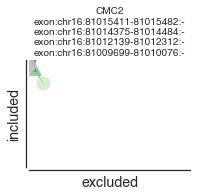

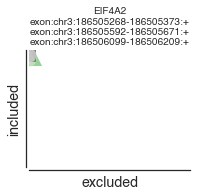

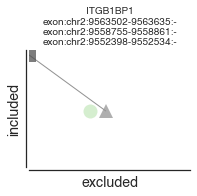

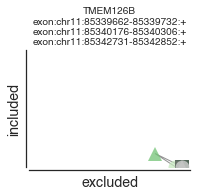

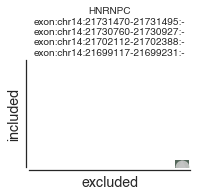

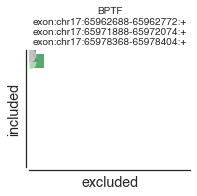

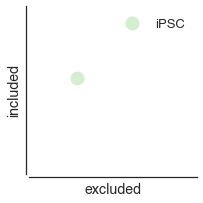

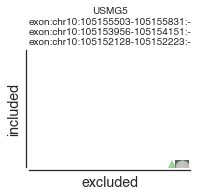

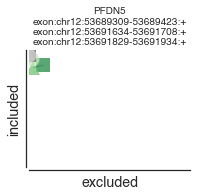

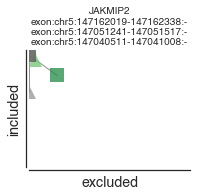

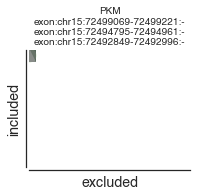

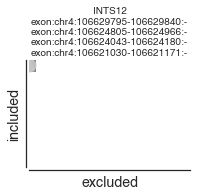

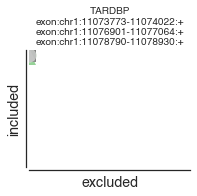

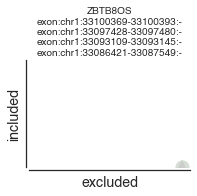

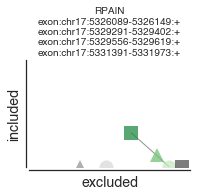

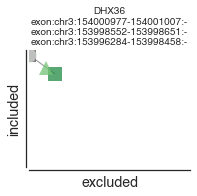

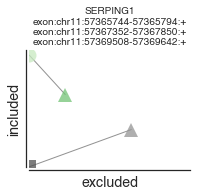

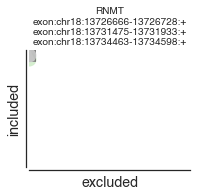

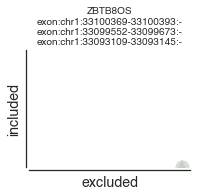

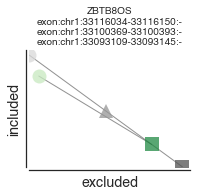

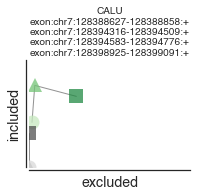

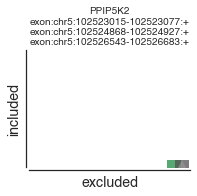

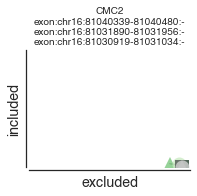

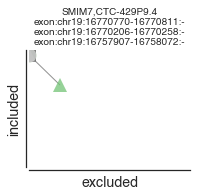

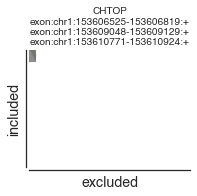

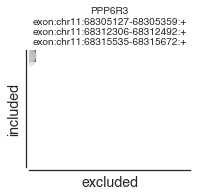

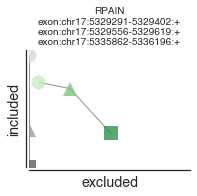

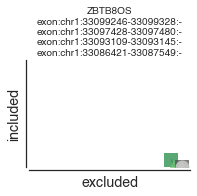

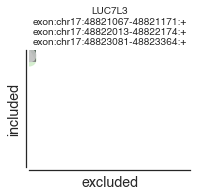

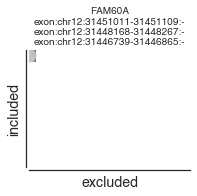

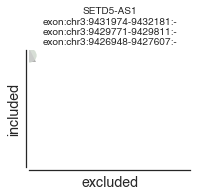

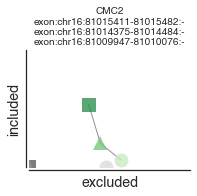

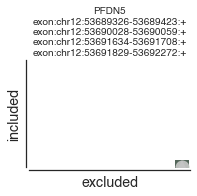

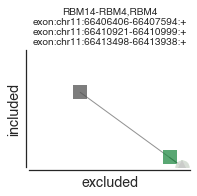

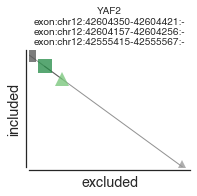

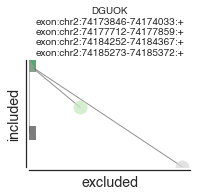

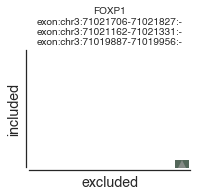

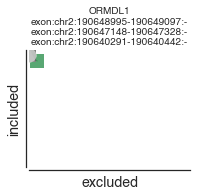

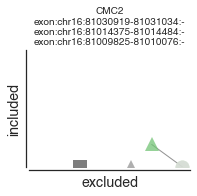

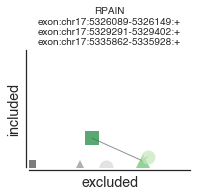

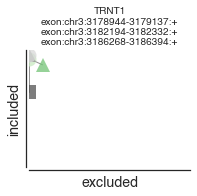

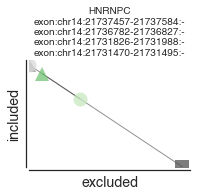

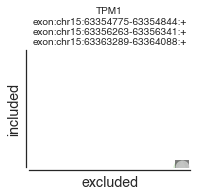

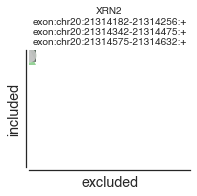

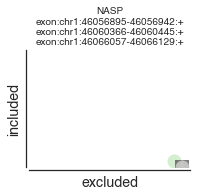

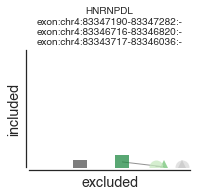

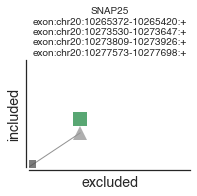

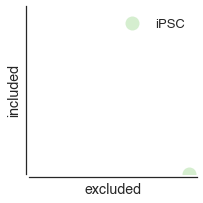

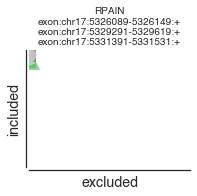

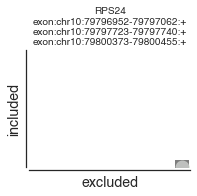

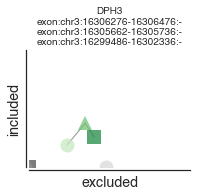

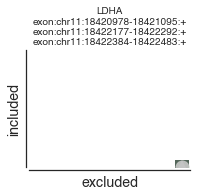

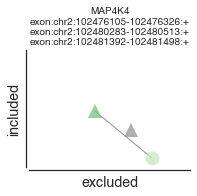

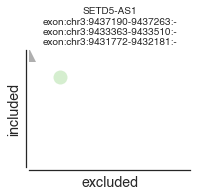

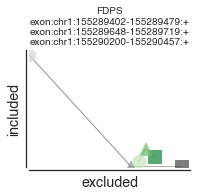

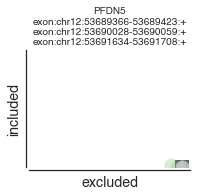

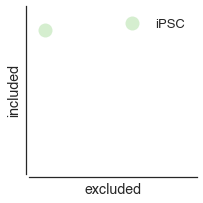

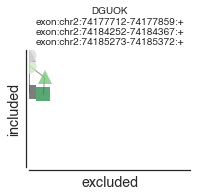

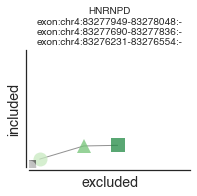

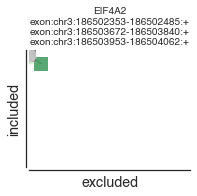

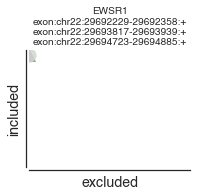

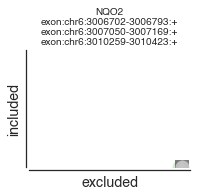

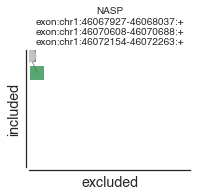

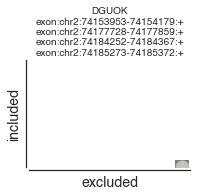

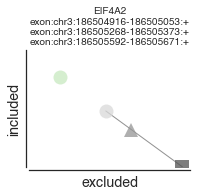

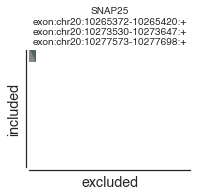

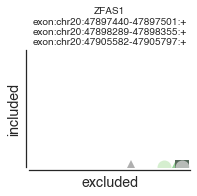

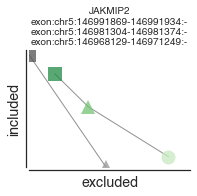

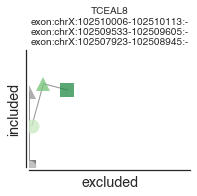

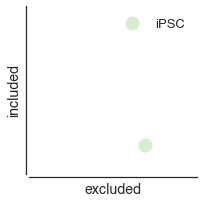

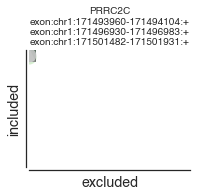

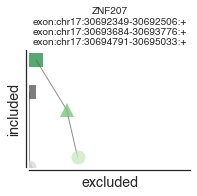

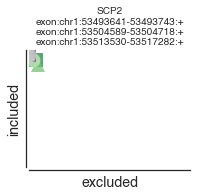

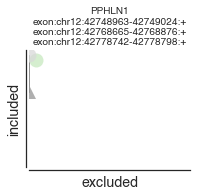

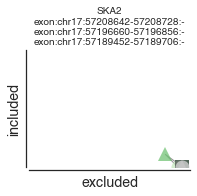

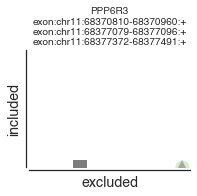

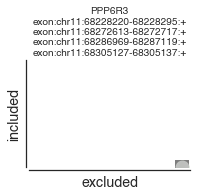

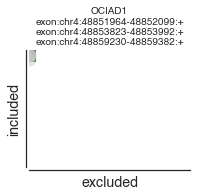

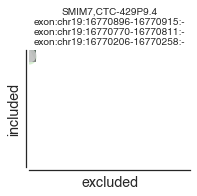

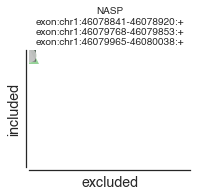

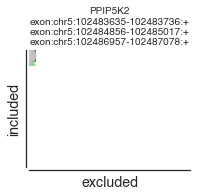

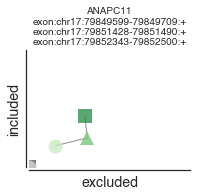

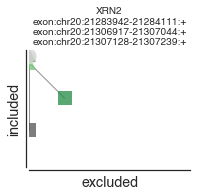

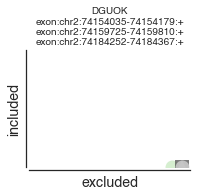

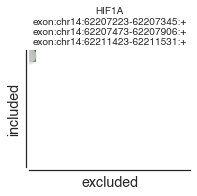

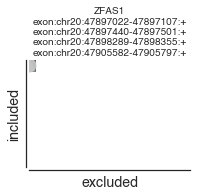

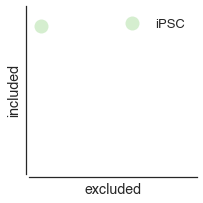

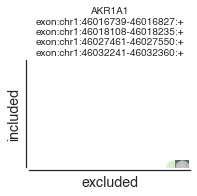

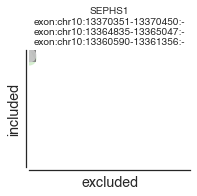

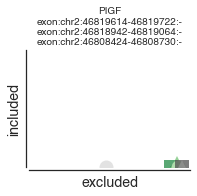

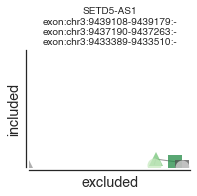

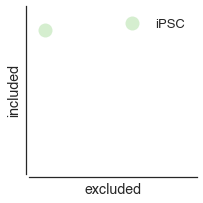

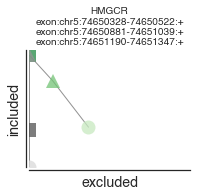

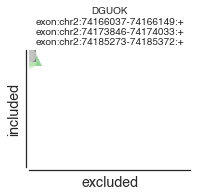

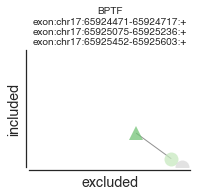

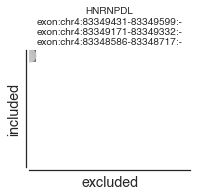

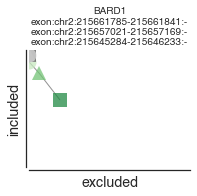

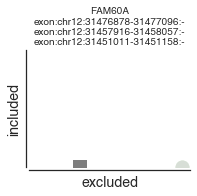

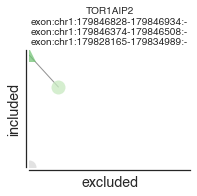

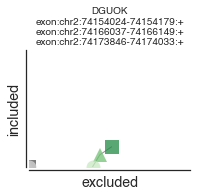

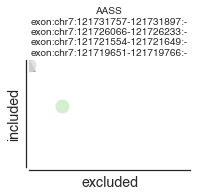

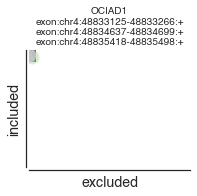

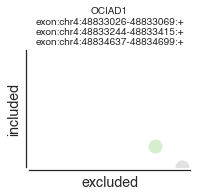

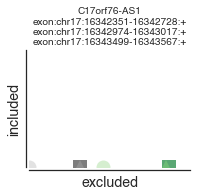

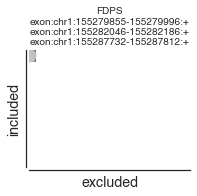

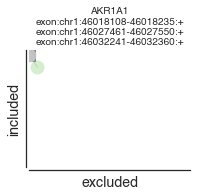

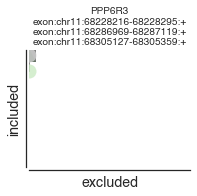

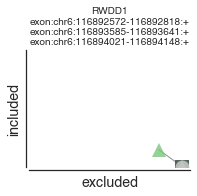

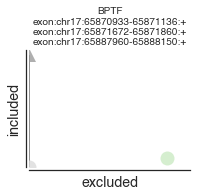

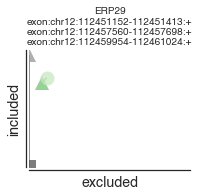

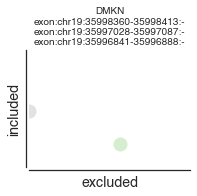

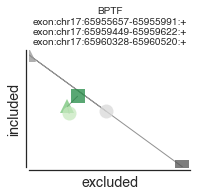

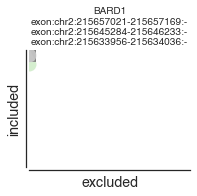

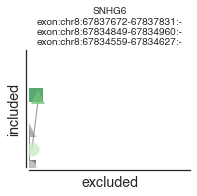

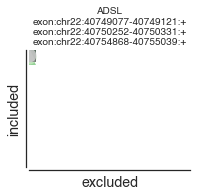

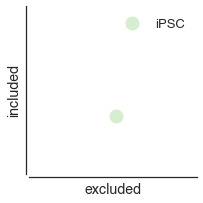

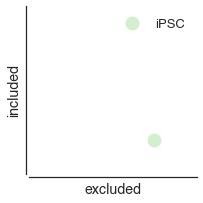

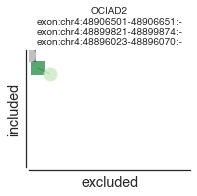

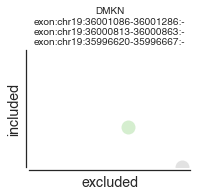

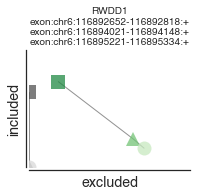

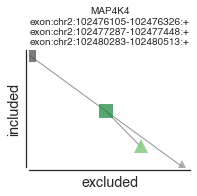

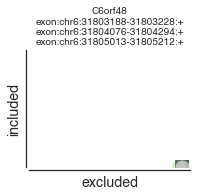

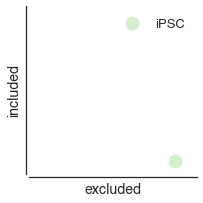

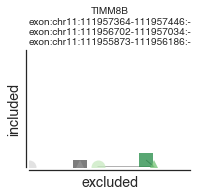

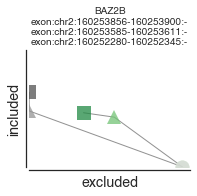

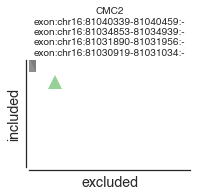

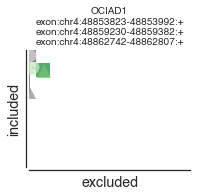

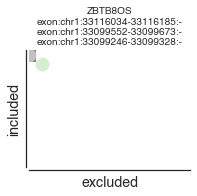

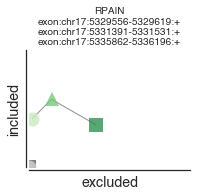

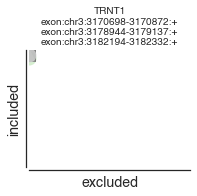

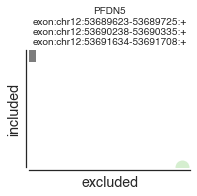

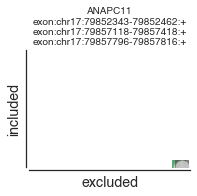

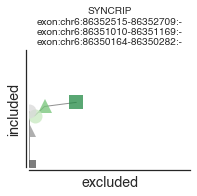

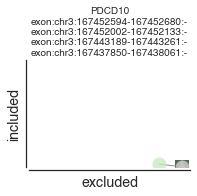

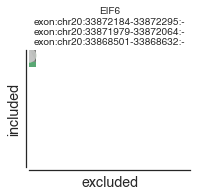

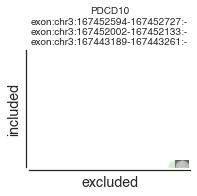

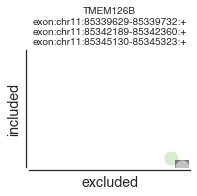

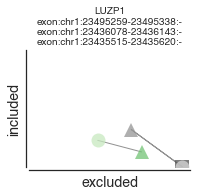

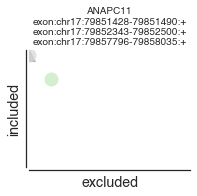

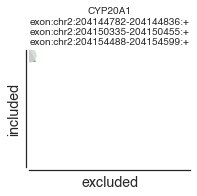

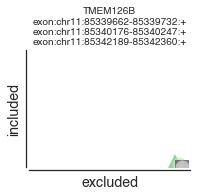

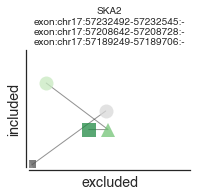

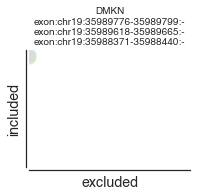

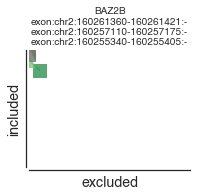

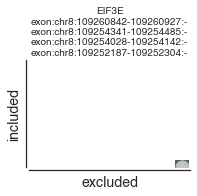

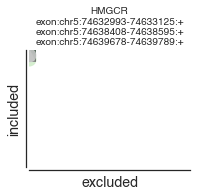

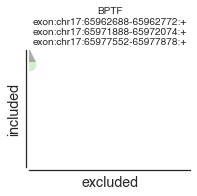

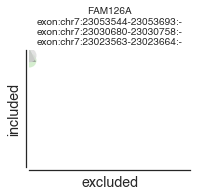

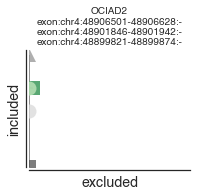

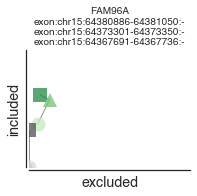

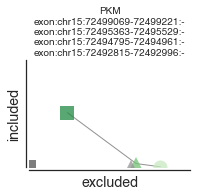

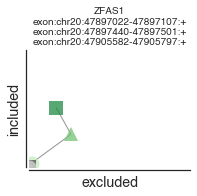

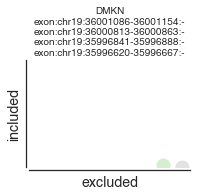

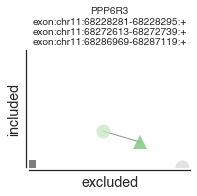

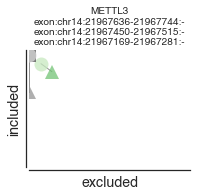

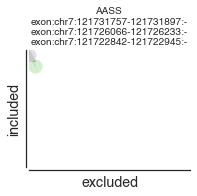

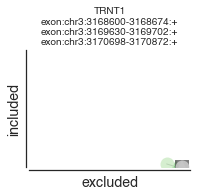

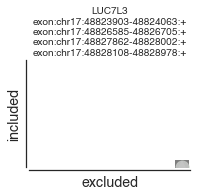

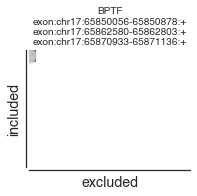

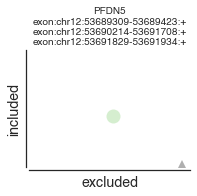

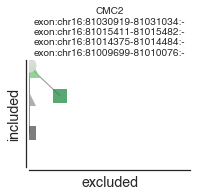

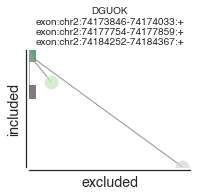

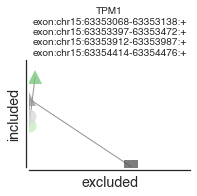

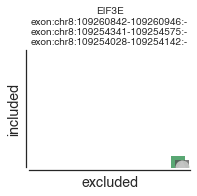

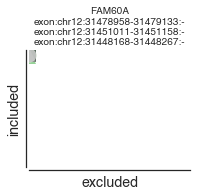

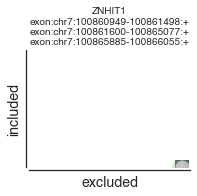

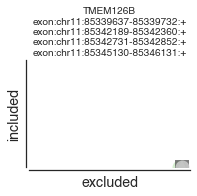

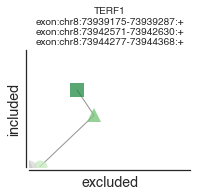

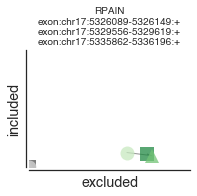

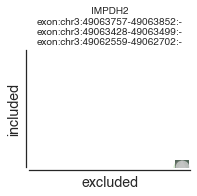

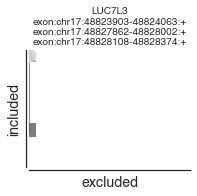

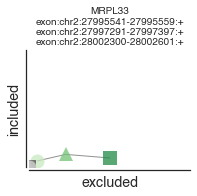

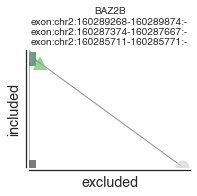

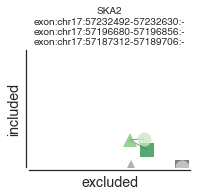

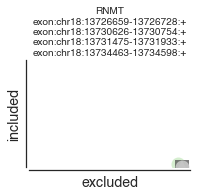

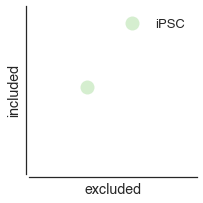

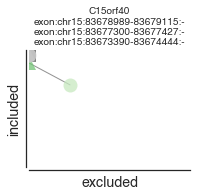

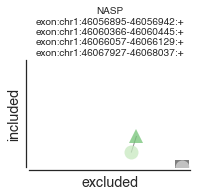

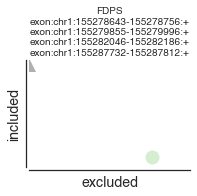

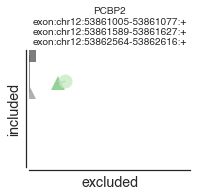

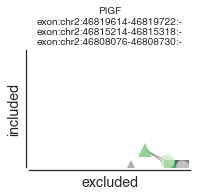

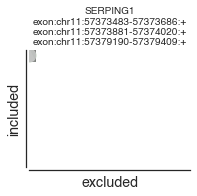

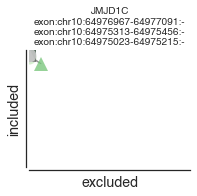

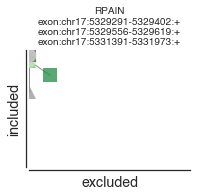

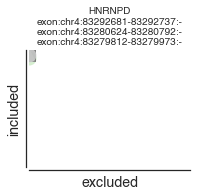

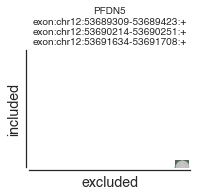

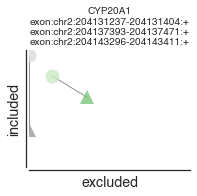

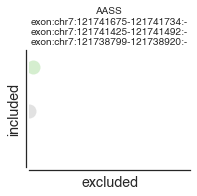

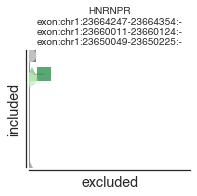

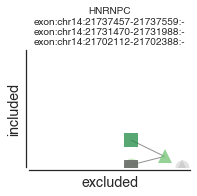

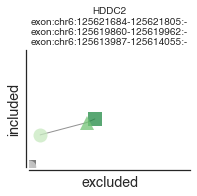

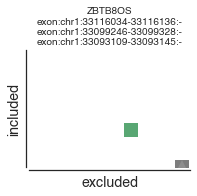

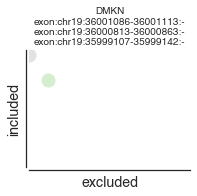

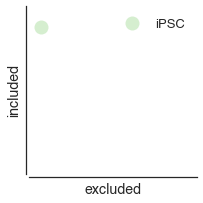

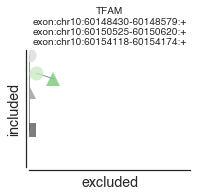

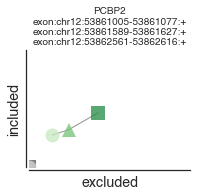

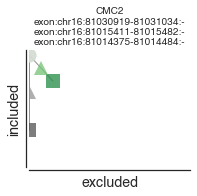

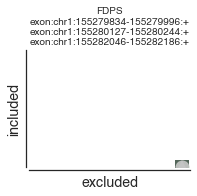

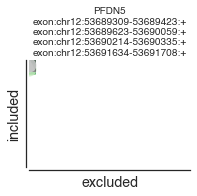

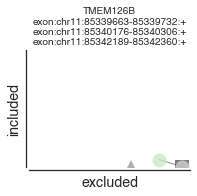

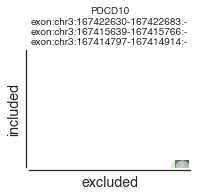

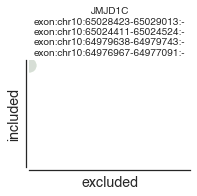

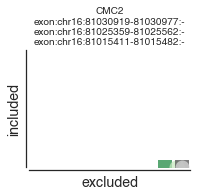

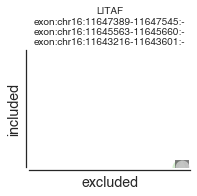

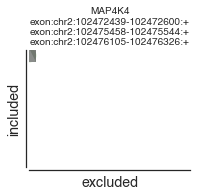

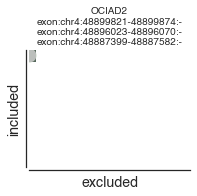

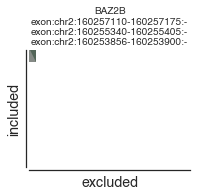

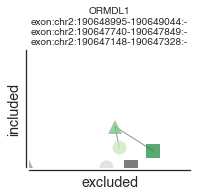

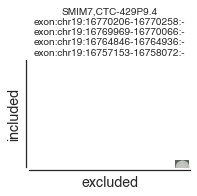

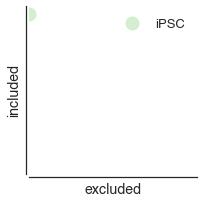

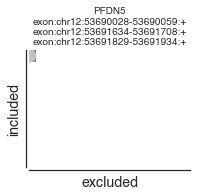

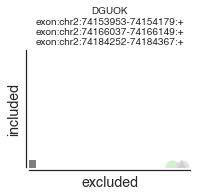

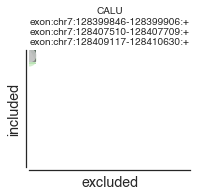

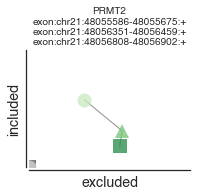

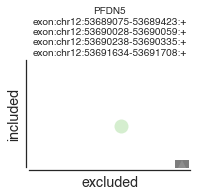

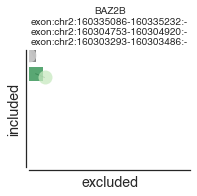

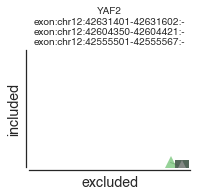

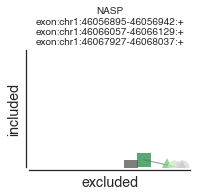

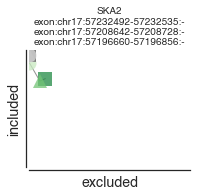

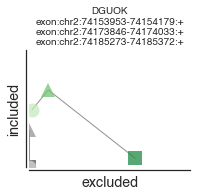

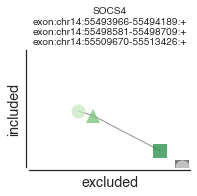

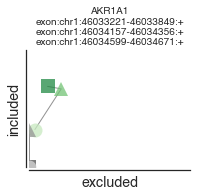

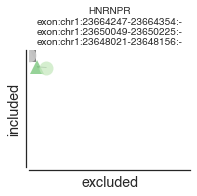

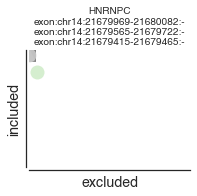

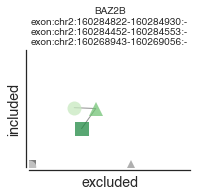

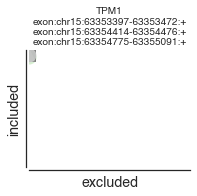

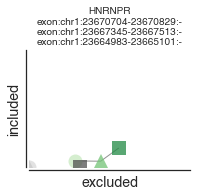

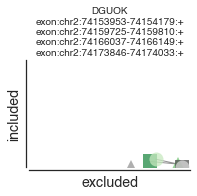

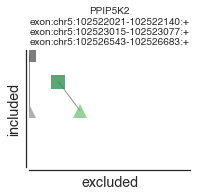

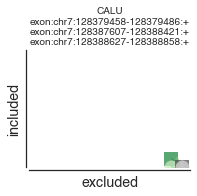

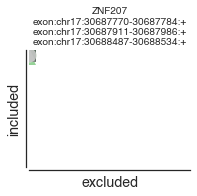

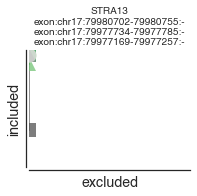

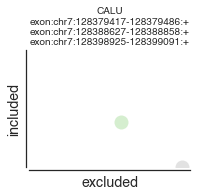

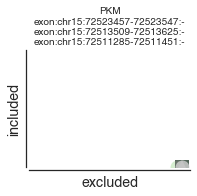

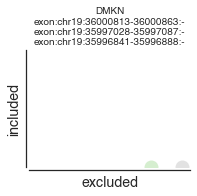

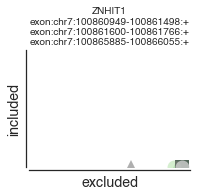

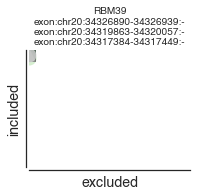

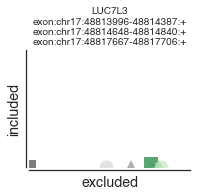

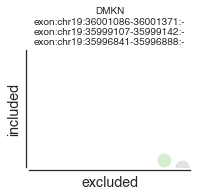

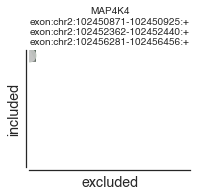

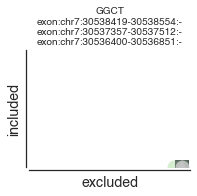

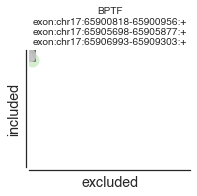

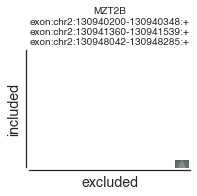

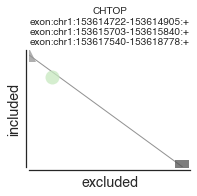

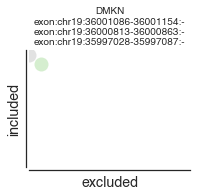

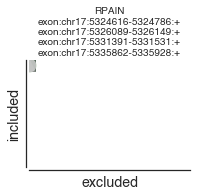

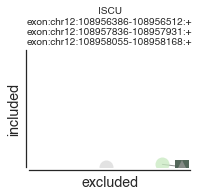

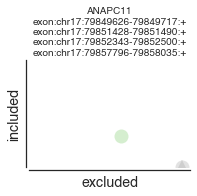

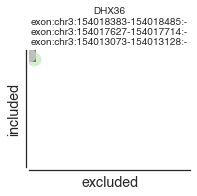

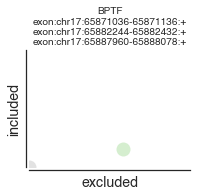

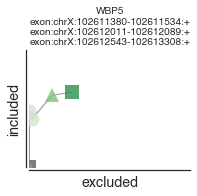

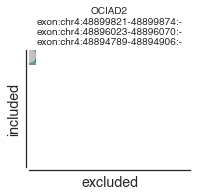

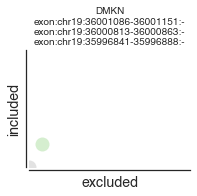

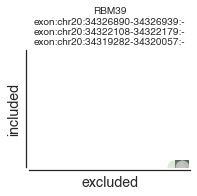

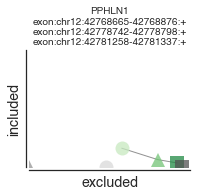

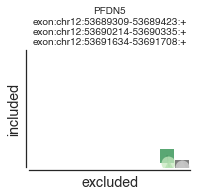

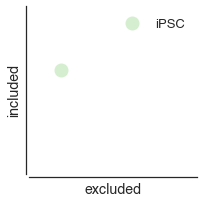

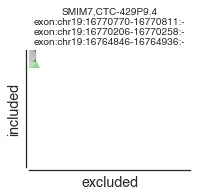

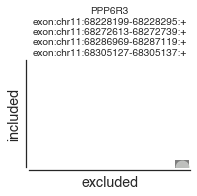

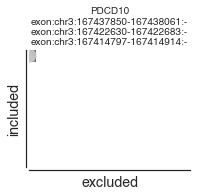

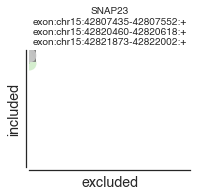

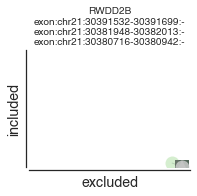

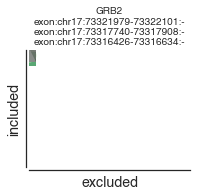

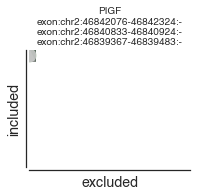

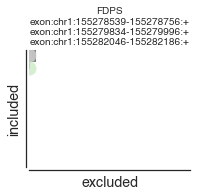

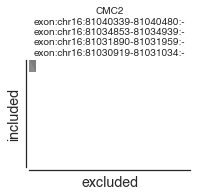

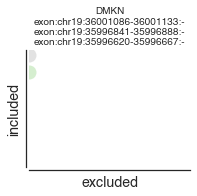

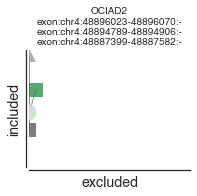

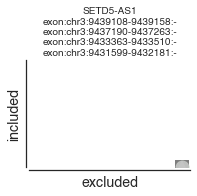

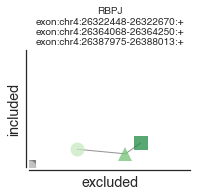

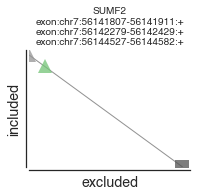

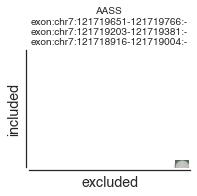

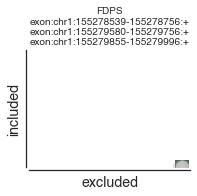

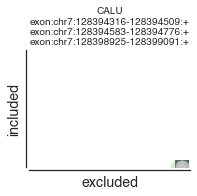

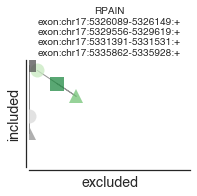

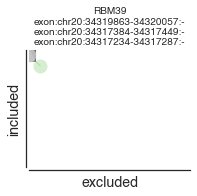

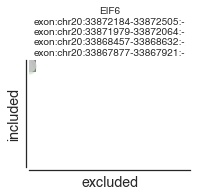

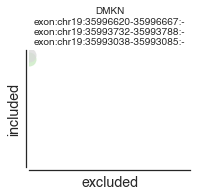

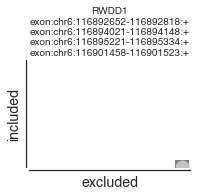

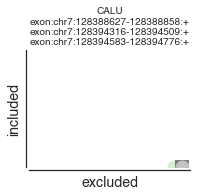

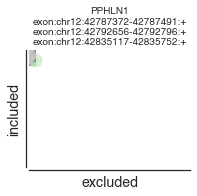

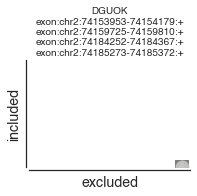

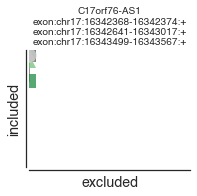

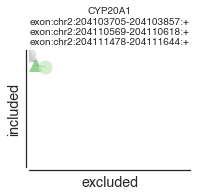

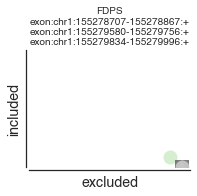

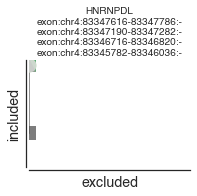

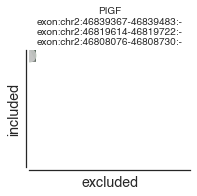

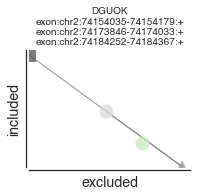

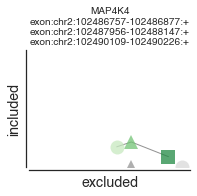

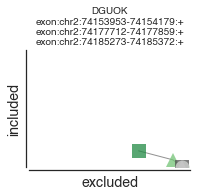

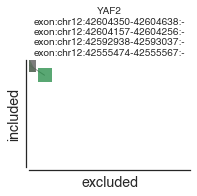

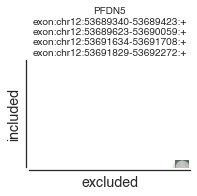

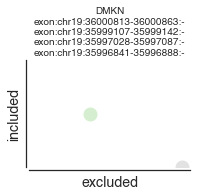

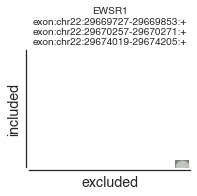

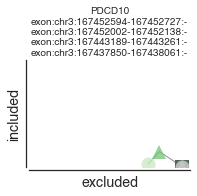

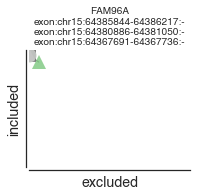

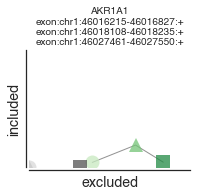

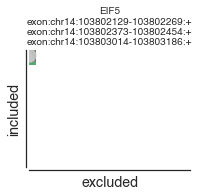

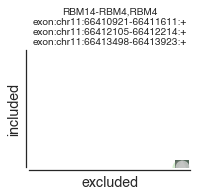

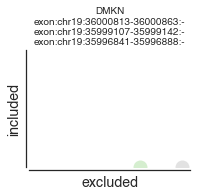

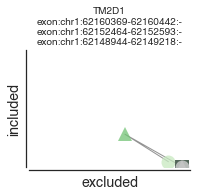

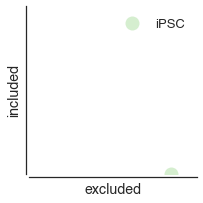

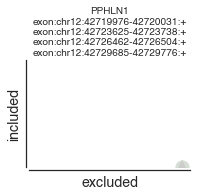

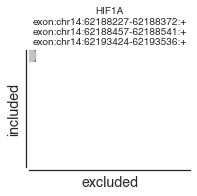

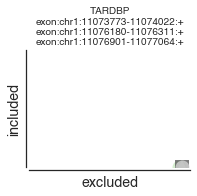

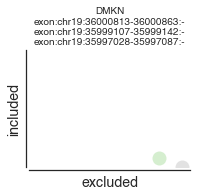

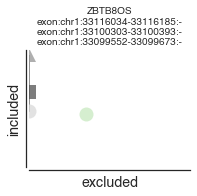

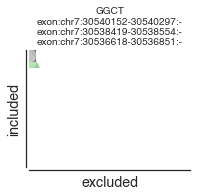

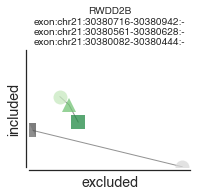

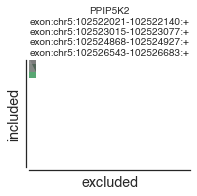

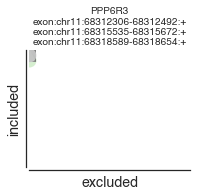

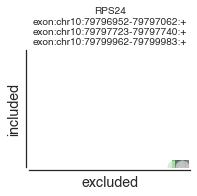

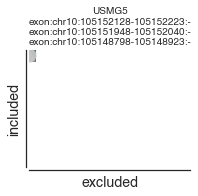

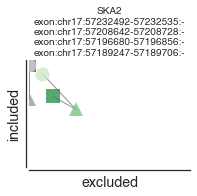

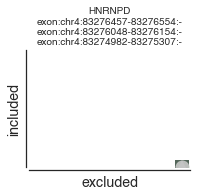

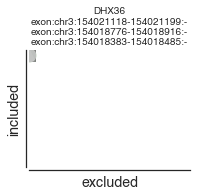

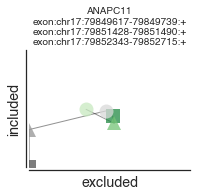

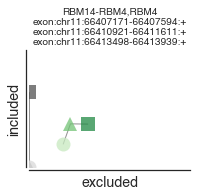

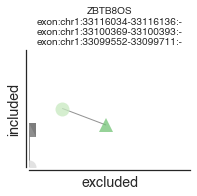

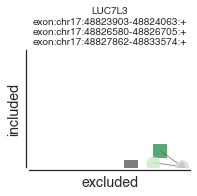

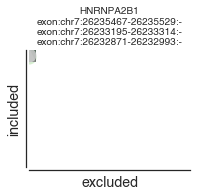

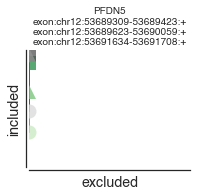

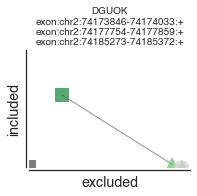

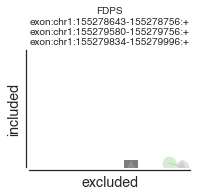

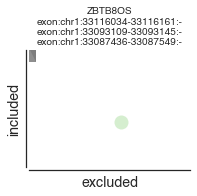

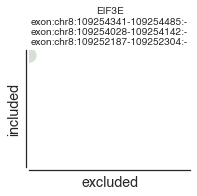

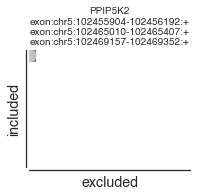

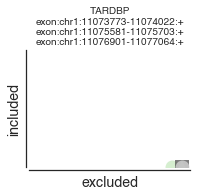

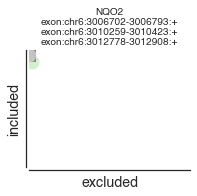

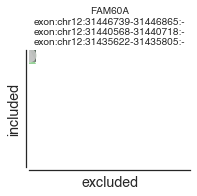

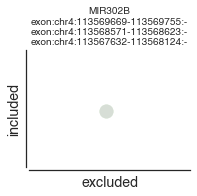

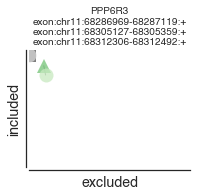

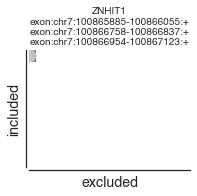

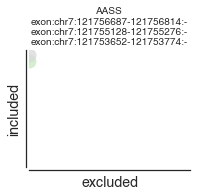

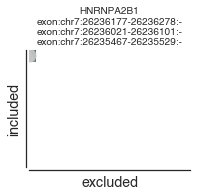

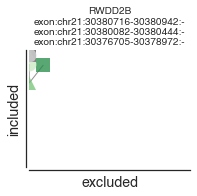

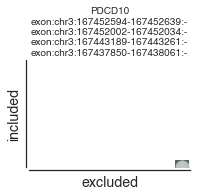

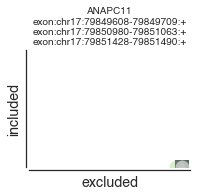

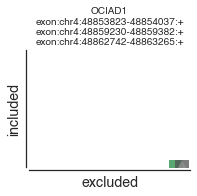

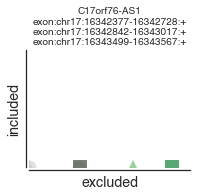

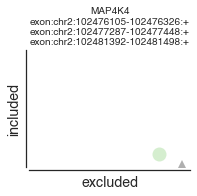

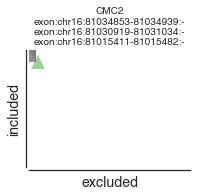

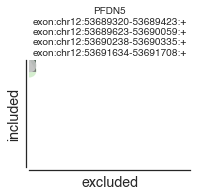

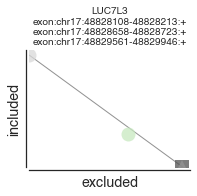

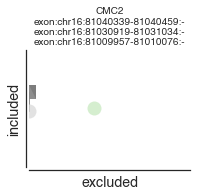

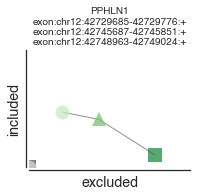

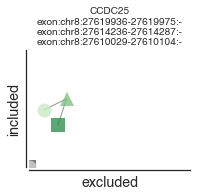

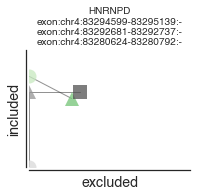

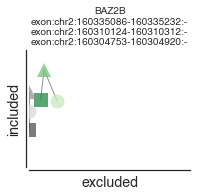

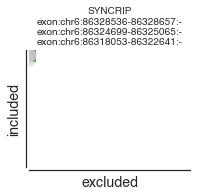

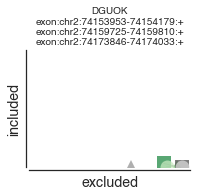

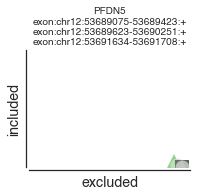

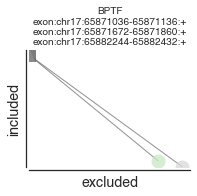

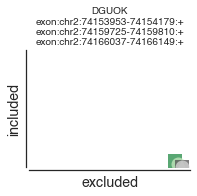

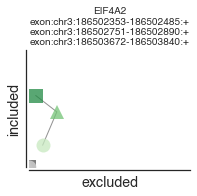

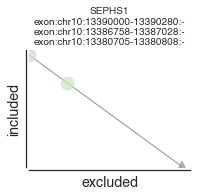

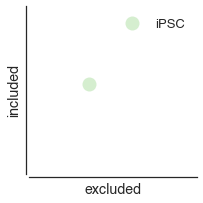

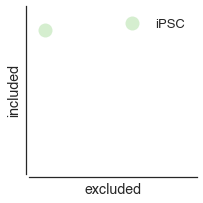

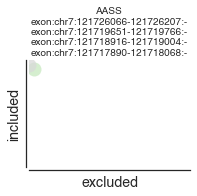

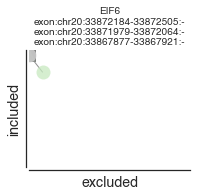

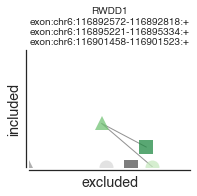

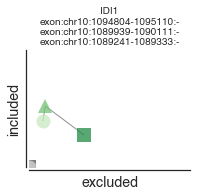

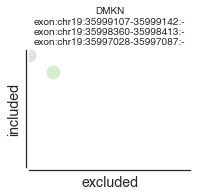

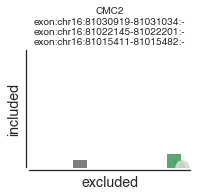

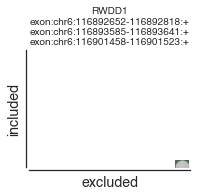

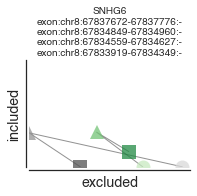

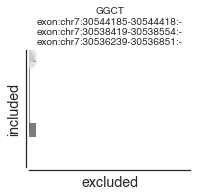

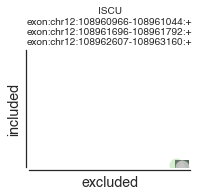

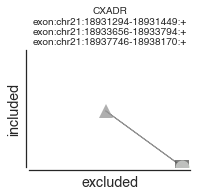

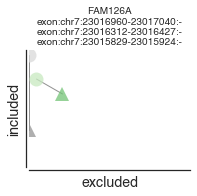

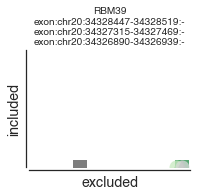

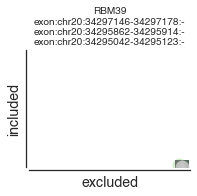

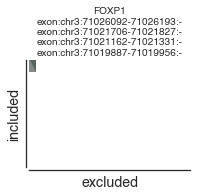

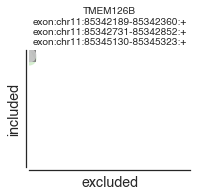

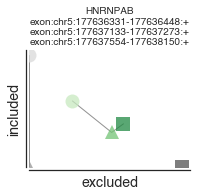

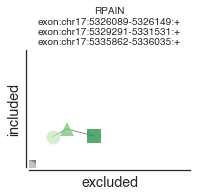

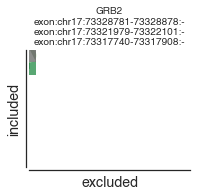

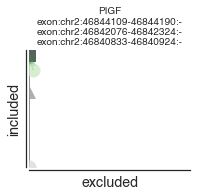

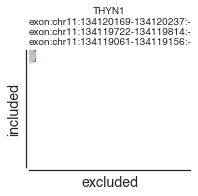

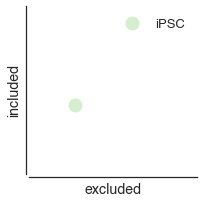

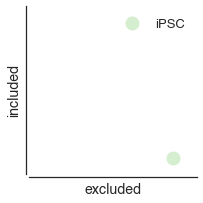

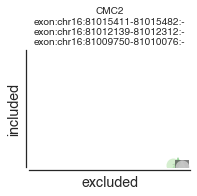

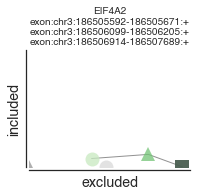

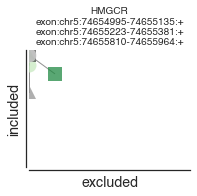

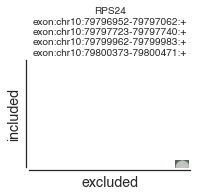

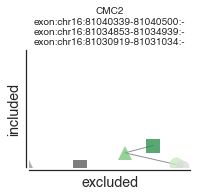

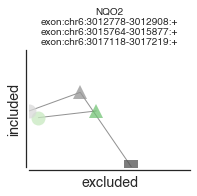

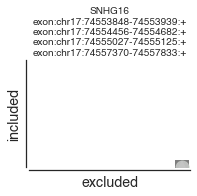

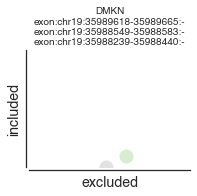

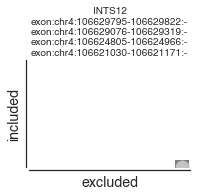

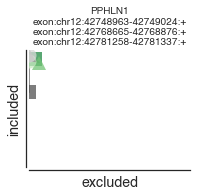

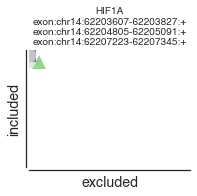

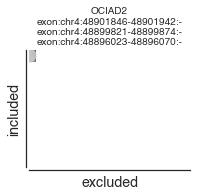

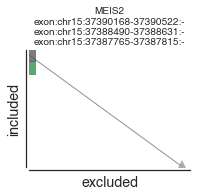

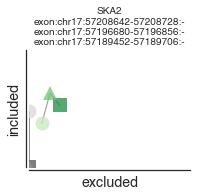

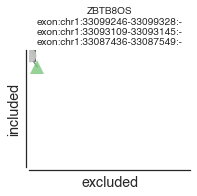

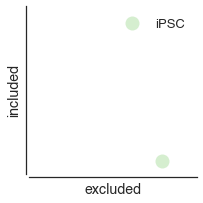

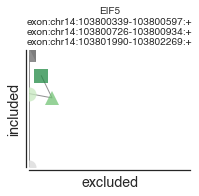

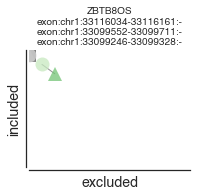

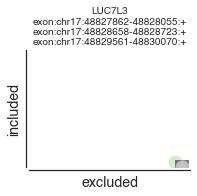

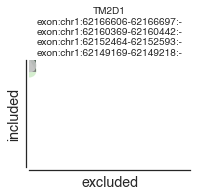

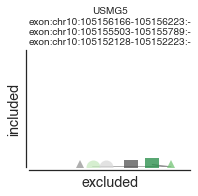

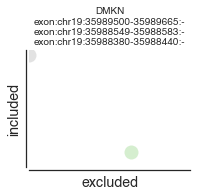

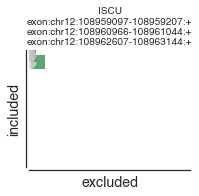

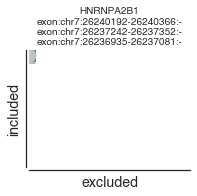

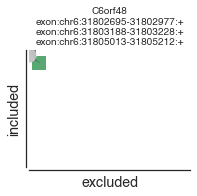

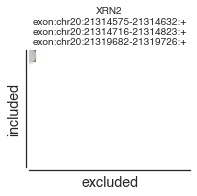

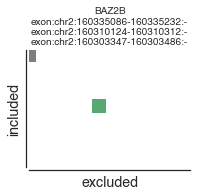

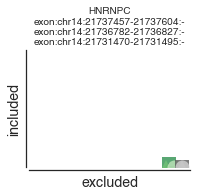

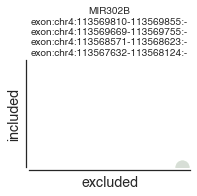

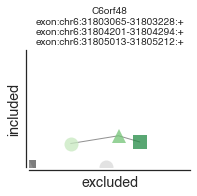

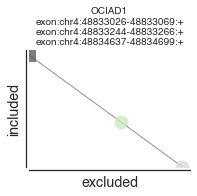

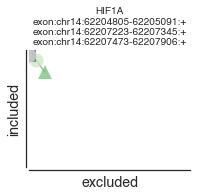

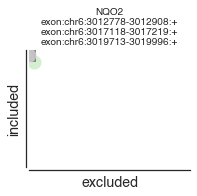

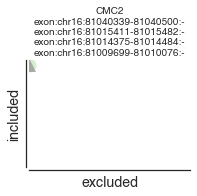

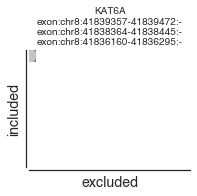

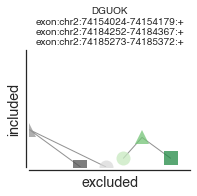

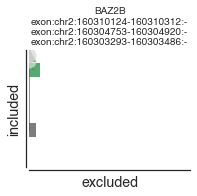

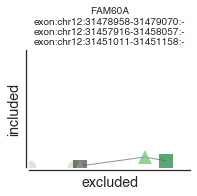

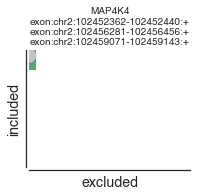

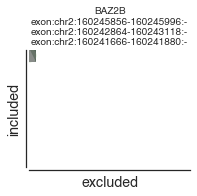

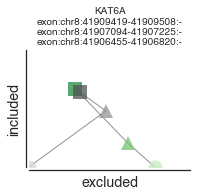

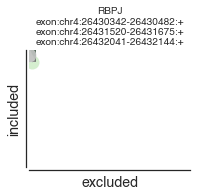

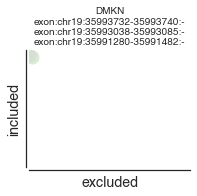

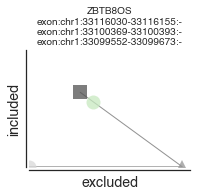

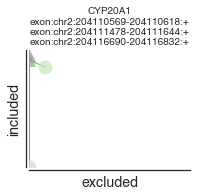

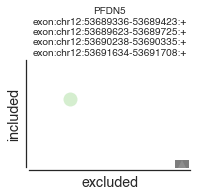

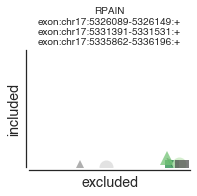

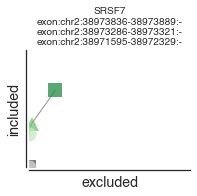

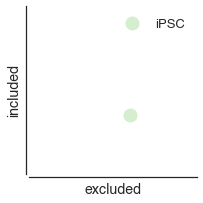

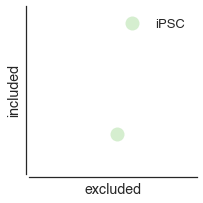

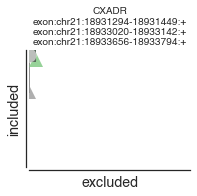

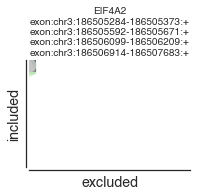

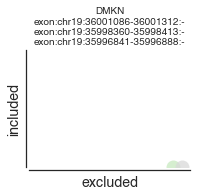

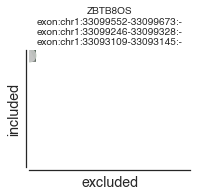

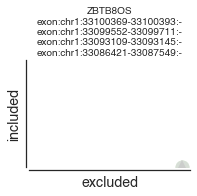

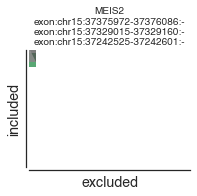

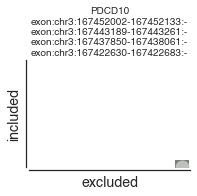

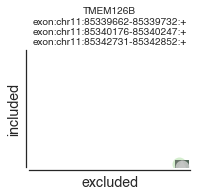

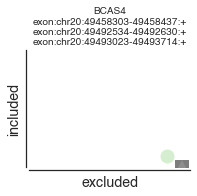

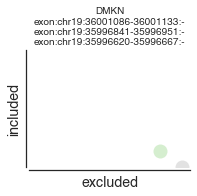

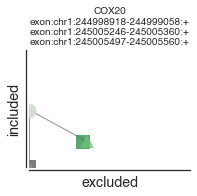

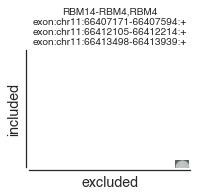

In [58]:
for i, event in enumerate(events_to_plot):
    
    if event in singles_waypoints_index.index:
        gene_name = study.splicing.feature_data['gene_name'][event]
        try:
            fig, ax = plt.subplots(figsize=(3, 3))
            bonvoyage.visualize.voyageplot(singles_waypoints_index, event, 
                                           study.phenotype_to_color, study.phenotype_to_marker, 
                                           study.phenotype_order, ax=ax)
            bonvoyage.visualize.voyageplot(pooled_waypoints_index, event, 
                                           pooled_phenotype_to_color, study.phenotype_to_marker, 
                                           study.phenotype_order, ax=ax)
            ax.legend_.set_visible(False)
    #     fig = plt.gcf() 
            sns.despine()
            title = '{}\n{}'.format(gene_name, '\n'.join(event.split('@')))
            ax.set_title(title, fontsize=10)
            fig.tight_layout()
            fig.savefig('{}/{}_{}_no_legend.pdf'.format(voyageplot_folder, gene_name, event))
        except KeyError:
            continue
#     if i > 3:
#         break